# Classical Music NER with Spacy v3




**AUTHOR: CAMELIA CIOLAC**  
ciolac_c@inria-alumni.fr


In this mini-project we train a Spacy Named Entity Recognition model on titles of classical music compositions in French. We are interested to identify the work type, instruments, tonality (key), tempo, given that the titles may contain abbeviations thereof.   
We need to develop a custom Spacy tokenizer due to the spellings of the titles, and, in one of the experiments, we train Word2Vec embeddings with Gensim.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
from IPython.core.display import display, HTML, Image
#display(HTML("<style>.container { width:100% !important; }</style>"))

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle, Circle
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

from PIL import Image as pilim
import seaborn as sns
%matplotlib inline

In [ ]:
!mkdir -p "/content/gdrive/My Drive/classicmusic_radio/"

In [3]:
import os

os.environ["WORK_FOLDER"] = "/content/gdrive/My Drive/classicmusic_radio/"

---------------------------------------------

--------------------------------------------

## Setup Doccano VM on GCP

### Pull Docker image from Docker Hub and push it to Google Container Registry

Check Docker image releases at: https://hub.docker.com/r/doccano/doccano  

On localhost in a terminal:

```
docker pull doccano/doccano

docker image ls | grep doccano
doccano/doccano         latest      a04c15332e48    2 days ago     866MB


docker tag doccano/doccano gcr.io/classicalmusicradio/doccano

docker image ls | grep doccano
doccano/doccano                            latest              a04c15332e48        2 days ago          866MB
gcr.io/classicalmusicradio/doccano         latest              a04c15332e48        2 days ago          866MB


gcloud auth configure-docker

docker push gcr.io/classicalmusicradio/doccano


```

### Deploy VM from Docker image on Compute Engine

Create Compute Engine VM instance running Docker image  
(see docs at https://cloud.google.com/sdk/gcloud/reference/compute/instances/create-with-container )


Choose the stable one and execute:

```
gcloud compute instances create-with-container instance-doccano \
    --zone=us-west2-c \
    --machine-type=n1-standard-1 \
    --container-image=gcr.io/classicalmusicradio/doccano \
    --container-env=ADMIN_USERNAME=admin,ADMIN_EMAIL=mail@mail.mail,ADMIN_PASSWORD=passdocc \
    --tags=doccano,http-server,https-server



Created [https://www.googleapis.com/compute/v1/projects/classicalmusicradio/zones/us-west2-c/instances/instance-doccano].
NAME              ZONE        MACHINE_TYPE   PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
instance-doccano  us-west2-c  n1-standard-1                 ...        34.102.22.221  RUNNING

```

We need a firewall rule for port 8000, with the tag doccano (see tags above):

```

gcloud compute firewall-rules create "doccanorule" \
      --allow=tcp:8000   --direction=INGRESS \
      --source-ranges="0.0.0.0/0" \
      --description="Allowing TCP traffic to doccano" \
      --target-tags="doccano"


NAME         NETWORK  DIRECTION  PRIORITY  ALLOW     DENY  DISABLED
doccanorule  default  INGRESS    1000      tcp:8000        False
```

Check results:

```
gcloud compute instances list


NAME                ZONE        MACHINE_TYPE   PREEMPTIBLE  INTERNAL_IP  EXTERNAL_IP    STATUS
instance-doccano    us-west2-c  n1-standard-1               ...          34.102.22.221  RUNNING

```
Port scanning to check if the remote node listens on port 8000:

```
nmap -p 8000 34.102.22.221

Starting Nmap 7.01 ( https://nmap.org ) at 2021-05-23 13:22 EEST
Nmap scan report for 221.22.102.34.bc.googleusercontent.com (34.102.22.221)
Host is up (0.19s latency).
PORT     STATE SERVICE
8000/tcp open  http-alt

Nmap done: 1 IP address (1 host up) scanned in 0.67 seconds

```

Now we can successfully launch Doccano in browser at http://34.102.22.221:8000/


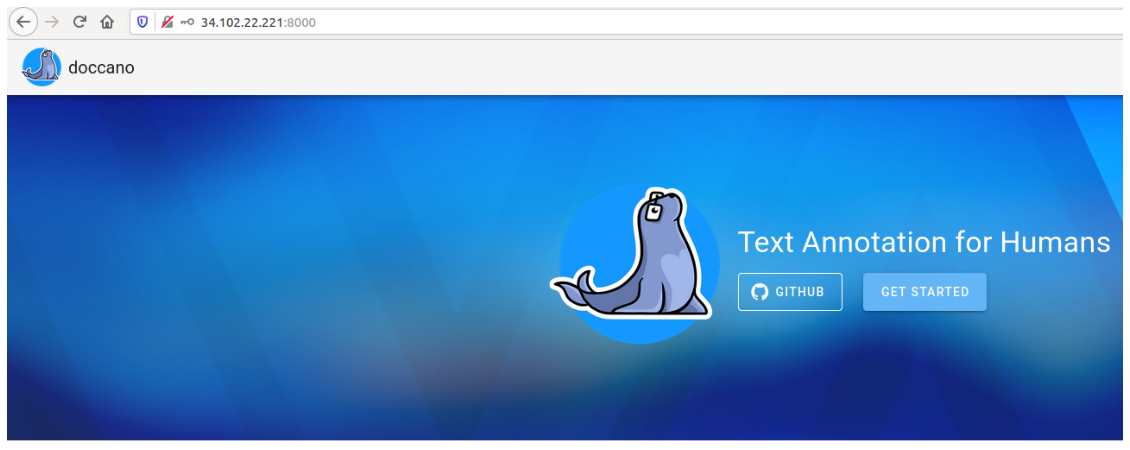

In [59]:
im = pilim.open(os.environ["WORK_FOLDER"] + "SCR_DOCCANO_GCE.png")
fig,ax = plt.subplots(1,1, figsize = (20,10))
ax.imshow(im)
ax.axis("off");

We can also ssh in the VM to  inspect docker processes:

```
gcloud beta compute ssh --project "classicalmusicradio" \
                        --zone "us-west2-c" "instance-doccano" 



docker info

=== RESPONSE ===
Client:
 Context:    default
 Debug Mode: false

Server:
 Containers: 2
  Running: 2
  Paused: 0
  Stopped: 0
 Images: 3
 Server Version: 20.10.3
 ...
 Operating System: Container-Optimized OS from Google
 OSType: linux
 Architecture: x86_64
 CPUs: 1
 Total Memory: 3.601GiB
 Name: instance-doccano
 ...

#=====================================================================

docker ps --format "table {{.ID}}\t{{.Image}}\t{{.Command}}\t{{.Names}}"

CONTAINER ID   IMAGE                                                       COMMAND                  NAMES
7fafa3e87f04   gcr.io/classicalmusicradio/doccano                          "/doccano/tools/run.…"   klt-instance-doccano-ngdk
3d7952725001   gcr.io/stackdriver-agents/stackdriver-logging-agent:1.8.4   "/entrypoint.sh /usr…"   stackdriver-logging-agent



docker logs --tail 10 7fafa3e87f04

docker volume ls

DRIVER    VOLUME NAME
local     f0c2ad81467c09106c8bf360de14633ea0d45bc06b5c22a7274f9710f1bc7894


exit

```

------------------------

----------------------

##Setup on Colab VM

In [4]:
%%bash

sudo apt-get install tree > /dev/null 2>&1

### parsing JSON
sudo apt-get install jq  > /dev/null 2>&1
#is neded by pyjq
sudo apt-get install autoconf libtool > /dev/null 2>&1


In [5]:
%%capture
%%bash

### parsing YAML
sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys CC86BB64
sudo add-apt-repository ppa:rmescandon/yq

sudo apt install yq -y

In [6]:
!pip3 install --upgrade pip

     |████████████████████████████████| 1.6MB 11.6MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1


In [7]:
%%bash

TMP_SETUP_FOLDER=/tmp/

cat <<EOF > $TMP_SETUP_FOLDER/requirements.txt

gensim==4.0.1

#tools
Unidecode==1.2.0
pyjq
xmltodict
tabulate
more-itertools==8.7.0
inflecteur

EOF

pip install -q -r $TMP_SETUP_FOLDER/requirements.txt

In [8]:
!pip show gensim

Name: gensim
Version: 4.0.1
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPL-2.1-only
Location: /usr/local/lib/python3.7/dist-packages
Requires: scipy, numpy, smart-open
Required-by: 


#### Setup Spacy

In [9]:
!pip show spacy | grep "Version"
!pip install --upgrade -q spacy
!pip show spacy | grep "Version"

Version: 2.2.4
     |████████████████████████████████| 12.8 MB 99 kB/s 
     |████████████████████████████████| 456 kB 47.0 MB/s 
     |████████████████████████████████| 1.1 MB 40.4 MB/s 
     |████████████████████████████████| 9.1 MB 37.1 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 113 kB 65.2 MB/s 
Version: 3.0.6


In [10]:
!pip show spacy

Name: spacy
Version: 3.0.6
Summary: Industrial-strength Natural Language Processing (NLP) in Python
Home-page: https://spacy.io
Author: Explosion
Author-email: contact@explosion.ai
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: numpy, setuptools, typer, srsly, pydantic, wasabi, murmurhash, typing-extensions, jinja2, blis, requests, packaging, pathy, catalogue, cymem, tqdm, thinc, spacy-legacy, preshed
Required-by: fastai, en-core-web-sm


In [11]:
%%bash
#list only folders in Spacy install path
ls -d /usr/local/lib/python3.7/dist-packages/spacy/*/

/usr/local/lib/python3.7/dist-packages/spacy/cli/
/usr/local/lib/python3.7/dist-packages/spacy/displacy/
/usr/local/lib/python3.7/dist-packages/spacy/lang/
/usr/local/lib/python3.7/dist-packages/spacy/matcher/
/usr/local/lib/python3.7/dist-packages/spacy/ml/
/usr/local/lib/python3.7/dist-packages/spacy/pipeline/
/usr/local/lib/python3.7/dist-packages/spacy/__pycache__/
/usr/local/lib/python3.7/dist-packages/spacy/tests/
/usr/local/lib/python3.7/dist-packages/spacy/tokens/
/usr/local/lib/python3.7/dist-packages/spacy/training/


In [12]:
!python -m spacy download fr_core_news_lg > /dev/null 

2021-06-09 16:02:45.057446: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


**Notes:**


In [13]:
%%bash

#tree ignoring bytecode cache
tree /usr/local/lib/python3.7/dist-packages/spacy/lang/fr -I "__pycache__"

echo "----------------------------------------------------------"

echo -e "EXAMPLES STOPWORDS FOR FRENCH: \n"

head -n 15 /usr/local/lib/python3.7/dist-packages/spacy/lang/fr/stop_words.py

echo "----------------------------------------------------------"

echo -e "EXAMPLES OF EXCEPTIONS TO TOKENIZATION FOR FRENCH: \n"

head -n 250 /usr/local/lib/python3.7/dist-packages/spacy/lang/fr/_tokenizer_exceptions_list.py | tail -n 25

/usr/local/lib/python3.7/dist-packages/spacy/lang/fr
├── examples.py
├── __init__.py
├── lemmatizer.py
├── lex_attrs.py
├── punctuation.py
├── stop_words.py
├── syntax_iterators.py
├── _tokenizer_exceptions_list.py
└── tokenizer_exceptions.py

0 directories, 9 files
----------------------------------------------------------
EXAMPLES STOPWORDS FOR FRENCH: 

STOP_WORDS = set(
    """
a à â abord afin ah ai aie ainsi ait allaient allons
alors anterieur anterieure anterieures apres après as assez attendu au
aucun aucune aujourd aujourd'hui aupres auquel aura auraient aurait auront
aussi autre autrement autres autrui aux auxquelles auxquels avaient
avais avait avant avec avoir avons ayant

bas basee bat

c' c’ ça car ce ceci cela celle celle-ci celle-là celles celles-ci celles-là celui
celui-ci celui-là cent cependant certain certaine certaines certains certes ces
cet cette ceux ceux-ci ceux-là chacun chacune chaque chez ci cinq cinquantaine cinquante
cinquantième cinquième combien comme co

In [14]:
%%bash

#find folder
FLD=$(find /usr/local/lib/python3.7/dist-packages/ -type d -name 'fr_core_news_lg')
#echo "$FLD"

#tree it
tree --du -h "$FLD"


echo "----------------------------------------------------------"

num_keys=$(cat /usr/local/lib/python3.7/dist-packages/fr_core_news_lg/fr_core_news_lg-3.0.0/vocab/strings.json | wc -l)
echo -e "$num_keys KEYS IN VOCAB \n"

head -n 1550 /usr/local/lib/python3.7/dist-packages/fr_core_news_lg/fr_core_news_lg-3.0.0/vocab/strings.json | tail -n 25

echo "----------------------------------------------------------"



/usr/local/lib/python3.7/dist-packages/fr_core_news_lg
├── [611M]  fr_core_news_lg-3.0.0
│   ├── [5.8K]  accuracy.json
│   ├── [4.9K]  attribute_ruler
│   │   └── [ 948]  patterns
│   ├── [5.0K]  config.cfg
│   ├── [9.2M]  lemmatizer
│   │   └── [9.2M]  lookups
│   │       └── [9.2M]  lookups.bin
│   ├── [ 18K]  meta.json
│   ├── [106K]  morphologizer
│   │   ├── [ 27K]  cfg
│   │   └── [ 75K]  model
│   ├── [6.6M]  ner
│   │   ├── [ 191]  cfg
│   │   ├── [6.6M]  model
│   │   └── [ 253]  moves
│   ├── [303K]  parser
│   │   ├── [ 192]  cfg
│   │   ├── [298K]  model
│   │   └── [ 652]  moves
│   ├── [212K]  senter
│   │   ├── [   4]  cfg
│   │   └── [208K]  model
│   ├── [6.5M]  tok2vec
│   │   ├── [   4]  cfg
│   │   └── [6.5M]  model
│   ├── [1.4M]  tokenizer
│   └── [587M]  vocab
│       ├── [6.5M]  key2row
│       ├── [   1]  lookups.bin
│       ├── [7.8M]  strings.json
│       └── [572M]  vectors
├── [ 236]  __init__.py
├── [ 18K]  meta.json
└── [4.4K]  __pycache__
    └── [ 450] 

---------------------------------------

----------------------------------------

### IMPORT PACKAGES

In [15]:
import pandas as pd
import numpy as np

#------------------------------------------

import requests

import spacy
from spacy import displacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from spacy.tokens import DocBin
from spacy.tokens import Doc, Token, Span
from spacy.training import Example
from spacy.language import Language

import gensim
from gensim.test.utils import get_tmpfile

from inflecteur import inflecteur

#------------------------------------------

from lxml import etree
import xmltodict

import json
import pickle
import pyjq


#----------------------------------------

import pprint
from tabulate import tabulate
from tqdm import tqdm

import math
import random 

import re
import string
import time
import datetime


import os
import glob
import shutil
from shutil import copyfile
import sys

import collections as coll
import itertools
from more_itertools import unique_everseen, flatten

import io
import copy

import textwrap

#multiprocessing.dummy is exactly the same as multiprocessing module, but uses threads instead 
from multiprocessing.dummy import Pool as ThreadPool

/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [16]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    warnings.filterwarnings("ignore",category=FutureWarning)
    

#to mute SettingWithCopyWarning
pd.options.mode.chained_assignment = None
    
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [17]:
pp = pprint.PrettyPrinter(width=150, compact=True)


def utility_print_lists_columnized(long_list, num_cols_columnize = 5):
    """ columnize print of list of strings"""
    
    num_columns = num_cols_columnize
    num_rows = int(len(long_list)/num_columns) 

    list_aux = []
    for ii in range(num_rows):
        list_aux.append(long_list[num_columns * ii: num_columns *(ii+1)])

    list_aux.append(long_list[num_columns * num_rows:])

    print(tabulate(list_aux, tablefmt="plain"))


def utility_dir(obj):
    utility_print_lists_columnized([el for el in dir(obj) if el[0]!="_"],
                                   num_cols_columnize = 7)

------------------

------------------

# Train Spacy model for Custom NER

## Preliminaries - behaviour with pretrained pipeline

In [17]:
%%bash

echo -e "EXPLORE DERIVATES OF WORD 'SYMPHONIE' IN VOCAB \n"

cat /usr/local/lib/python3.7/dist-packages/fr_core_news_lg/fr_core_news_lg-3.0.0/vocab/strings.json | grep "ymphoni"

EXPLORE DERIVATES OF WORD 'SYMPHONIE' IN VOCAB 

  "symphonique",
  "symphonie",
  "Symphonie",
  "symphonies",
  "symphoniques",
  "Symphonique",
  "Symphonies",
  "Symphonia",
  "Symphonic",
  "Symphoniques",
  "Symphoniker",
  "symphoniste",
  "symphonia",


In [16]:
nlp_pretrained = spacy.load("fr_core_news_lg")
vocab_pretrained = nlp_pretrained.vocab

utility_dir(vocab_pretrained)

add_flag        cfg         data_dir  from_bytes        from_disk  get_noun_chunks  get_vector
has_vector      lang        length    lex_attr_getters  lookups    morphology       prune_vectors
reset_vectors   set_vector  strings   to_bytes          to_disk    vectors          vectors_length
writing_system


In [19]:
print([ss for ss in vocab_pretrained.strings if "ymphoni" in ss.lower()])

['symphonique', 'symphonie', 'Symphonie', 'symphonies', 'symphoniques', 'Symphonique', 'Symphonies', 'Symphonia', 'Symphonic', 'Symphoniques', 'Symphoniker', 'symphoniste', 'symphonia']


In [ ]:
#recap
utility_dir(spacy.tokens.Token)

ancestors      check_flag        children        cluster      conjuncts      dep           dep_
doc            ent_id            ent_id_         ent_iob      ent_iob_       ent_kb_id     ent_kb_id_
ent_type       ent_type_         get_extension   has_dep      has_extension  has_head      has_morph
has_vector     head              i               idx          iob_strings    is_alpha      is_ancestor
is_ascii       is_bracket        is_currency     is_digit     is_left_punct  is_lower      is_oov
is_punct       is_quote          is_right_punct  is_sent_end  is_sent_start  is_space      is_stop
is_title       is_upper          lang            lang_        left_edge      lefts         lemma
lemma_         lex               lex_id          like_email   like_num       like_url      lower
lower_         morph             n_lefts         n_rights     nbor           norm          norm_
orth           orth_             pos             pos_         prefix         prefix_       prob
rank          

In [18]:
def apply_pipeline_1(ss, nlp, flag_display = False):

    doc = nlp(ss)

    list_pipeline = []
    for tok in  doc:
        list_pipeline.append((tok.i, tok.text, tok.tag_, tok.pos_, tok.dep_, 
                              tok.ent_iob_, tok.ent_type_, tok.is_oov
                              ))


    print(tabulate(list_pipeline, tablefmt="fancy_grid",
                headers=["i", "token", "tag", "pos", "dep", "iob", "entity type", "oov"])) 

    if flag_display is True:
        displacy.render(doc, style='dep', jupyter=True, options={'distance': 100})

In [ ]:
s_demo1 = "Concerto pour vcelle n°4:Allegro final"
apply_pipeline_1(ss = s_demo1, nlp = nlp_pretrained, flag_display=True)


╒═════╤══════════╤═══════╤═══════╤════════╤═══════╤═══════════════╤═══════╕
│   i │ token    │ tag   │ pos   │ dep    │ iob   │ entity type   │ oov   │
╞═════╪══════════╪═══════╪═══════╪════════╪═══════╪═══════════════╪═══════╡
│   0 │ Concerto │ PROPN │ PROPN │ ROOT   │ O     │               │ False │
├─────┼──────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   1 │ pour     │ ADP   │ ADP   │ case   │ O     │               │ False │
├─────┼──────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   2 │ vcelle   │ NOUN  │ NOUN  │ nmod   │ O     │               │ True  │
├─────┼──────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   3 │ n°       │ NOUN  │ NOUN  │ ROOT   │ O     │               │ False │
├─────┼──────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   4 │ 4        │ NUM   │ NUM   │ nummod │ O     │               │ False │
├─────┼──────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   5 │ :   

In [ ]:
s_demo2 = "Symphonie pour vcelle & b.c. en mi bemol: 2e mvt "
apply_pipeline_1(ss = s_demo2, nlp = nlp_pretrained, flag_display=True)

╒═════╤═══════════╤═══════╤═══════╤═════════╤═══════╤═══════════════╤═══════╕
│   i │ token     │ tag   │ pos   │ dep     │ iob   │ entity type   │ oov   │
╞═════╪═══════════╪═══════╪═══════╪═════════╪═══════╪═══════════════╪═══════╡
│   0 │ Symphonie │ NOUN  │ NOUN  │ ROOT    │ B     │ MISC          │ False │
├─────┼───────────┼───────┼───────┼─────────┼───────┼───────────────┼───────┤
│   1 │ pour      │ ADP   │ ADP   │ case    │ I     │ MISC          │ False │
├─────┼───────────┼───────┼───────┼─────────┼───────┼───────────────┼───────┤
│   2 │ vcelle    │ NOUN  │ NOUN  │ nmod    │ I     │ MISC          │ True  │
├─────┼───────────┼───────┼───────┼─────────┼───────┼───────────────┼───────┤
│   3 │ &         │ CCONJ │ CCONJ │ cc      │ I     │ MISC          │ False │
├─────┼───────────┼───────┼───────┼─────────┼───────┼───────────────┼───────┤
│   4 │ b.c       │ NOUN  │ NOUN  │ conj    │ I     │ MISC          │ True  │
├─────┼───────────┼───────┼───────┼─────────┼───────┼───────────

Note the multiple roots in the dependency tree

Also note that some abbreviations are out of vocabulary. We get zero-filled vector for them

In [ ]:
vocab_pretrained.get_vector("vcelle")[0:100]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:
vocab_pretrained.get_vector("violoncelle")[0:100]

array([-0.62509  , -0.11277  , -1.3972   ,  2.2455   , -0.70683  ,
        1.1332   ,  0.34114  ,  1.4858   ,  1.7096   ,  0.30708  ,
       -3.3026   , -0.60695  , -1.0479   , -0.22225  , -1.0148   ,
       -1.956    ,  1.3556   ,  0.58172  ,  0.09664  , -0.29942  ,
        0.4107   , -0.50654  , -1.0737   ,  0.30518  , -0.052833 ,
        0.47243  , -2.0243   , -0.25242  , -0.10276  ,  0.53786  ,
       -0.8249   , -0.44773  ,  1.6759   , -0.93591  ,  1.7354   ,
       -0.39511  , -0.53036  , -0.37848  , -0.72299  , -0.54562  ,
        0.91893  ,  0.65842  ,  0.85933  ,  1.5205   , -0.72436  ,
       -0.73193  ,  0.73837  ,  1.1693   , -2.6665   ,  0.64638  ,
        0.69622  ,  0.28324  , -0.25829  , -0.37611  ,  0.63039  ,
       -0.52705  , -0.078676 ,  1.3563   , -0.38557  , -1.1077   ,
        1.2831   , -0.81479  ,  0.13949  ,  1.715    ,  1.205    ,
       -0.33258  ,  1.6154   , -0.57504  , -1.6504   ,  0.11599  ,
       -1.2793   , -0.38472  , -1.1999   , -0.40313  ,  0.115 

In [ ]:
#sidenote: word vectors have size:
vocab_pretrained.get_vector("violoncelle").shape[0]

300

**Most similar vocabulary keys to a given one**

In [ ]:
help(vocab_pretrained.vectors.most_similar)

Help on built-in function most_similar:

most_similar(...) method of spacy.vectors.Vectors instance
    Vectors.most_similar(self, queries, *, batch_size=1024, n=1, sort=True)
    For each of the given vectors, find the n most similar entries
            to it, by cosine.
    
            Queries are by vector. Results are returned as a `(keys, best_rows,
            scores)` tuple. If `queries` is large, the calculations are performed in
            chunks, to avoid consuming too much memory. You can set the `batch_size`
            to control the size/space trade-off during the calculations.
    
            queries (ndarray): An array with one or more vectors.
            batch_size (int): The batch size to use.
            n (int): The number of entries to return for each query.
            sort (bool): Whether to sort the n entries returned by score.
            RETURNS (tuple): The most similar entries as a `(keys, best_rows, scores)`
                tuple.



In [ ]:
def print_most_similar(vocab_pretrained, target_word):

    v1 = vocab_pretrained.get_vector(target_word)

    ms = vocab_pretrained.vectors.most_similar(queries = np.array([v1]), n=10, sort = True)
    pp.pprint(ms)
    print("---------------------------------------")
    return [vocab_pretrained.strings[w] for w in ms[0][0]]

In [ ]:
#most similar to tonality key "fa"
print_most_similar(vocab_pretrained = vocab_pretrained, target_word = "fa")

(array([[18120200462163523762,  3113168160197081765,  7775713615660120927,
         5285833050308381350,  4731410125304877247,  6419771594745455138,
        16605163981368088708, 17369655117483032540, 15466573792636342652,
         2836599501096619328]], dtype=uint64),
 array([[ 15852,  33558,  19927,  37076, 323287,  69058, 115374, 213969,
        122385,  82053]], dtype=int32),
 array([[1.    , 0.6987, 0.6778, 0.5923, 0.573 , 0.5721, 0.5598, 0.5542,
        0.5517, 0.5331]], dtype=float32))
---------------------------------------


['fa', 'ut', 'ré', 'Fa', 'mib', 'dièse', 'ade', 'sib', '♭', 'Ut']

In [ ]:
#most similar to an instrument
print_most_similar(vocab_pretrained = vocab_pretrained, target_word = "violoncelle")

(array([[17899357206410011433, 15439585186299439618,  5803880149298027984,
         3925889112442944381, 15426786336894659118,  7459711215568239969,
         8425689848312774632, 16566101209765656689,  2691871600927186865,
          964127177486857783]], dtype=uint64),
 array([[ 17335, 124770,   8698,  23464,  36148, 263492,  20391,  19388,
         25070,   3602]], dtype=int32),
 array([[1.    , 0.9063, 0.8545, 0.8412, 0.833 , 0.7798, 0.7743, 0.7738,
        0.7688, 0.7686]], dtype=float32))
---------------------------------------


['violoncelle',
 'Violoncelle',
 'violon',
 'clarinette',
 'violoncelliste',
 'contrebasson',
 'soliste',
 'violoniste',
 'contrebasse',
 'piano']

In [ ]:
#most similar to an instrument abbrev that doesn't exist in vocab
print_most_similar(vocab_pretrained = vocab_pretrained, target_word = "vcelle")

(array([[ 1843513407833445213, 16875625775244447254,  4135037920198221584,
         5557690605201058113, 14405876695872892828, 16483321324414261831,
        13486429117489675359,  6152797077316221196,  8053599779940295475,
        16547792547373081141]], dtype=uint64),
 array([[500003, 166670, 166669, 166668, 166667, 166671, 166665, 166659,
        166663, 166666]], dtype=int32),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32))
---------------------------------------


['bemol:',
 'siliceuse',
 'Nettoyeurs',
 'idées',
 'Boundary',
 'Neuchatel',
 '34,9',
 'codice_5',
 'Assous',
 'Paya']




**An issue on tokenization of certain cases**

In [ ]:
#focus on "871-arrgt"
s_demo3 = "Le Clavier bien tempéré:Fugue n°2 BWV 871-arrgt Mozart"
apply_pipeline_1(ss = s_demo3, nlp = nlp_pretrained, flag_display=False)

╒═════╤═══════════╤═══════╤═══════╤════════╤═══════╤═══════════════╤═══════╕
│   i │ token     │ tag   │ pos   │ dep    │ iob   │ entity type   │ oov   │
╞═════╪═══════════╪═══════╪═══════╪════════╪═══════╪═══════════════╪═══════╡
│   0 │ Le        │ DET   │ DET   │ det    │ O     │               │ False │
├─────┼───────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   1 │ Clavier   │ PROPN │ PROPN │ ROOT   │ B     │ MISC          │ False │
├─────┼───────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   2 │ bien      │ ADV   │ ADV   │ advmod │ O     │               │ False │
├─────┼───────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   3 │ tempéré   │ VERB  │ VERB  │ acl    │ O     │               │ False │
├─────┼───────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   4 │ :         │ PUNCT │ PUNCT │ punct  │ O     │               │ False │
├─────┼───────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤

In [ ]:
#focus on "pianos:1er"
s_demo4 = "Concerto pour 3 pianos:1er mvt"
apply_pipeline_1(ss = s_demo4, nlp = nlp_pretrained, flag_display=False)

╒═════╤════════════╤═══════╤═══════╤════════╤═══════╤═══════════════╤═══════╕
│   i │ token      │ tag   │ pos   │ dep    │ iob   │ entity type   │ oov   │
╞═════╪════════════╪═══════╪═══════╪════════╪═══════╪═══════════════╪═══════╡
│   0 │ Concerto   │ PROPN │ PROPN │ ROOT   │ O     │               │ False │
├─────┼────────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   1 │ pour       │ ADP   │ ADP   │ case   │ O     │               │ False │
├─────┼────────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   2 │ 3          │ NUM   │ NUM   │ nummod │ O     │               │ False │
├─────┼────────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   3 │ pianos:1er │ NOUN  │ NOUN  │ nmod   │ O     │               │ True  │
├─────┼────────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   4 │ mvt        │ VERB  │ VERB  │ punct  │ O     │               │ False │
╘═════╧════════════╧═══════╧═══════╧════════╧═══════╧═══════════

In [ ]:
# focus on " Rêverie"-arrgt "
s_demo5 = "Scènes d'enfants: \"Rêverie\"-arrgt guitare"
apply_pipeline_1(ss = s_demo5, nlp = nlp_pretrained, flag_display=False)

╒═════╤════════════════╤═══════╤═══════╤═══════╤═══════╤═══════════════╤═══════╕
│   i │ token          │ tag   │ pos   │ dep   │ iob   │ entity type   │ oov   │
╞═════╪════════════════╪═══════╪═══════╪═══════╪═══════╪═══════════════╪═══════╡
│   0 │ Scènes         │ NOUN  │ NOUN  │ ROOT  │ O     │               │ False │
├─────┼────────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   1 │ d'             │ ADP   │ ADP   │ case  │ O     │               │ False │
├─────┼────────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   2 │ enfants        │ NOUN  │ NOUN  │ nmod  │ O     │               │ False │
├─────┼────────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   3 │ :              │ PUNCT │ PUNCT │ punct │ O     │               │ False │
├─────┼────────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   4 │ "              │ PUNCT │ PUNCT │ punct │ O     │               │ False │
├─────┼────────────────┼────

In [ ]:
#another example
s_demo6 = "Cantate\"Herr, wenn ich nur dir\"BuxWV 38"
apply_pipeline_1(ss = s_demo6, nlp = nlp_pretrained, flag_display=False)

╒═════╤══════════════╤═══════╤═══════╤═══════╤═══════╤═══════════════╤═══════╕
│   i │ token        │ tag   │ pos   │ dep   │ iob   │ entity type   │ oov   │
╞═════╪══════════════╪═══════╪═══════╪═══════╪═══════╪═══════════════╪═══════╡
│   0 │ Cantate"Herr │ PROPN │ PROPN │ ROOT  │ O     │               │ True  │
├─────┼──────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   1 │ ,            │ PUNCT │ PUNCT │ ROOT  │ O     │               │ False │
├─────┼──────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   2 │ wenn         │ NOUN  │ NOUN  │ ROOT  │ O     │               │ False │
├─────┼──────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   3 │ ich          │ X     │ X     │ dep   │ O     │               │ False │
├─────┼──────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   4 │ nur          │ ADV   │ ADV   │ dep   │ O     │               │ False │
├─────┼──────────────┼───────┼───────┼───────┼──────

---------------------

### Create a custom tokenizer to deal with special cases

see  
https://spacy.io/usage/linguistic-features#native-tokenizer-additions  
https://support.prodi.gy/t/guidance-on-how-to-add-tokenizer-rule/666  
https://stackoverflow.com/questions/55241927/spacy-intra-word-hyphens-how-to-treat-them-one-word



In [ ]:
#recap regex

#  ?:  is for non capturing group
#  ?=  is for positive look ahead
#  ?!  is for negative look ahead
#  ?<= is for positive look behind
#  ?<! is for negative look behind
# Lookahead and lookbehind are collectively called “lookaround”
# lookaheads position pointer where the pattern is matched, but don't consume the chars that make up the pattern

#digit followed by dash
print("non capturing group: ", re.search(r'(?:[\d])\-', '123-ab6-789') )
print("positive look ahead: ", re.search(r'(?=[\d][\-])', '123-ab6-789') )  #chain 2 lookaheads
print("positive look behind:", re.search(r'(?<=[\d])\-', '123-ab6-789') )

print("=============================================================================================")

#digit followed by dash  which is followed by digit

print("non capturing group AND non capturing group: ", re.search(r'(?:[\d])\-(?:[\d])', '123-ab6-789') )
print("positive look ahead AND non capturing group: ", re.search(r'(?=[\d][\-])(?:[\d])', '123-ab6-789') ) 
print("positive look behind AND non capturing group:", re.search(r'(?<=[\d])\-(?:[\d])', '123-ab6-789') )

print("----------------------------------------------------------------------------------------------")

print("non capturing group AND positive lookahead:   ", re.search(r'(?:[\d])\-(?=[\d])', '123-ab6-789') )
print("positive look ahead AND positive lookahead:   ", re.search(r'(?=[\d][\-][\d])', '123-ab6-789') )   #chain 3 lookaheads
print("positive look behind  AND positive lookahead: ", re.search(r'(?<=[\d])\-(?=[\d])', '123-ab6-789') )

print("----------------------------------------------------------------------------------------------")

#digit followed by dash which is not followed by digit

print("non capturing group AND negative look ahead:   ", re.search(r'(?:[\d])\-(?![\d])', '123-ab6-789') )
print("positive look ahead AND negative look ahead:   ", re.search(r'(?=[\d][\-])(?![\d])', '123-ab6-789') ) #because after the match, the pointer is on a digit, so it fails to be non-digit
print("positive look behind  AND negative look ahead: ", re.search(r'(?<=[\d])\-(?![\d])', '123-ab6-789') )


non capturing group:  <re.Match object; span=(2, 4), match='3-'>
positive look ahead:  <re.Match object; span=(2, 2), match=''>
positive look behind: <re.Match object; span=(3, 4), match='-'>
non capturing group AND non capturing group:  <re.Match object; span=(6, 9), match='6-7'>
positive look ahead AND non capturing group:  <re.Match object; span=(2, 3), match='3'>
positive look behind AND non capturing group: <re.Match object; span=(7, 9), match='-7'>
----------------------------------------------------------------------------------------------
non capturing group AND positive lookahead:    <re.Match object; span=(6, 8), match='6-'>
positive look ahead AND positive lookahead:    <re.Match object; span=(6, 6), match=''>
positive look behind  AND positive lookahead:  <re.Match object; span=(7, 8), match='-'>
----------------------------------------------------------------------------------------------
non capturing group AND negative look ahead:    <re.Match object; span=(2, 4), match

Great tool for debugging regex https://www.debuggex.com/

In [ ]:
#example
#note the usage of ? , in lookbehind and in lookahead, but also as quantifier (0 or 1) as in "\)?" 

ss = "Scènes d'enfants: \"Rêverie\"-arrgt guitare"
re.search(r'(?<=[A-Za-z0-9])\"\)?\-?(?=[A-Za-z])', ss)

<re.Match object; span=(26, 28), match='"-'>

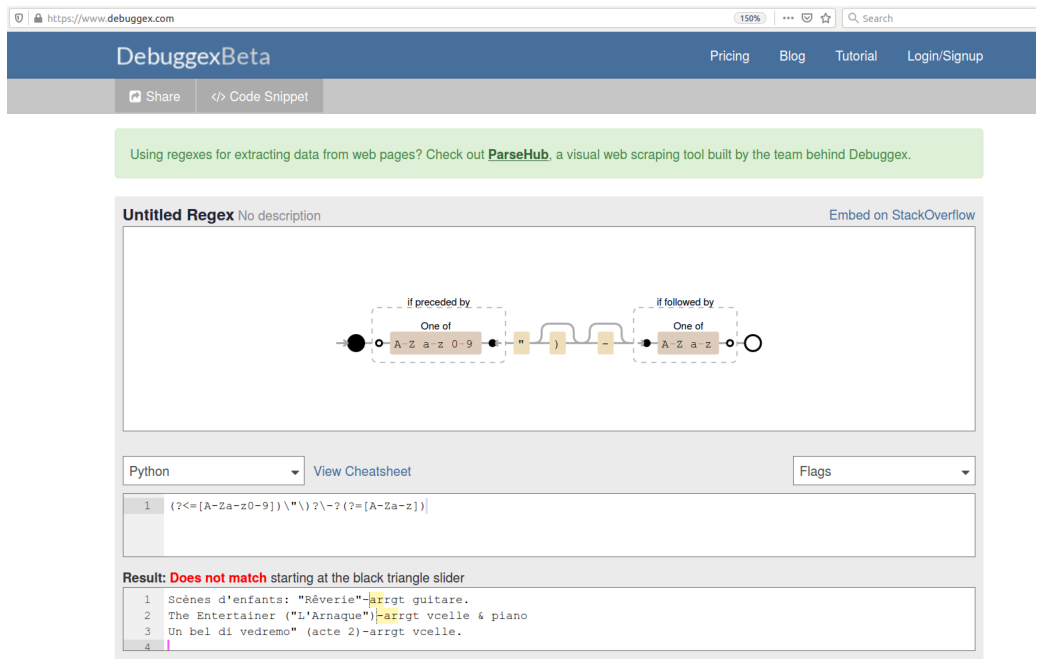

In [ ]:
im = pilim.open(os.environ["WORK_FOLDER"] + "debuggex.png")
fig,ax = plt.subplots(1,1, figsize = (30,12))
ax.imshow(im)
ax.axis("off");

In [ ]:
nlp_pretrained_2 = spacy.load("fr_core_news_lg")

In [40]:
def custom_tokenizer(nlp):
    
    #split on :, also split on dash between number and word
    #2nd: matches dash whose look behnd is digit (?<=[\d]) and whose look ahead is letter
    #3rd: matches quote optionally folowed by paranthesis and optionally followed by dash, all preceeded by alphanum and followed by letter
    #4th: matches dash optionally preceeded by paranthesis and optionally preceeded by dash, all preceeded by alphanum and followed by letter
    infixes = nlp.Defaults.infixes + [
                    r':',
                    r'(?<=[\d])\-(?=[A-Za-z])',
                    r'(?<=[A-Za-z0-9])\"\)?\-?(?=[A-Za-z])', 
                    r'(?<=[A-Za-z0-9])\"?\)?\-(?=[A-Za-z])', 
            ]
    infix_re = compile_infix_regex(infixes)

    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

    tknz = Tokenizer(nlp.vocab, 
                     prefix_search = prefix_re.search,
                     suffix_search = suffix_re.search,
                     infix_finditer = infix_re.finditer,
                     token_match = nlp.tokenizer.token_match,
                     rules = nlp.Defaults.tokenizer_exceptions)
    return tknz

In [ ]:
nlp_pretrained_2.tokenizer = custom_tokenizer(nlp_pretrained_2)

In [ ]:
#focus on "871-arrgt"
s_demo3 = "Le Clavier bien tempéré:Fugue n°2 BWV 871-arrgt Mozart"
apply_pipeline_1(ss = s_demo3, nlp = nlp_pretrained_2, flag_display=True)

╒═════╤═════════╤═══════╤═══════╤════════╤═══════╤═══════════════╤═══════╕
│   i │ token   │ tag   │ pos   │ dep    │ iob   │ entity type   │ oov   │
╞═════╪═════════╪═══════╪═══════╪════════╪═══════╪═══════════════╪═══════╡
│   0 │ Le      │ DET   │ DET   │ det    │ O     │               │ False │
├─────┼─────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   1 │ Clavier │ PROPN │ PROPN │ ROOT   │ B     │ MISC          │ False │
├─────┼─────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   2 │ bien    │ ADV   │ ADV   │ advmod │ O     │               │ False │
├─────┼─────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   3 │ tempéré │ VERB  │ VERB  │ acl    │ O     │               │ False │
├─────┼─────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   4 │ :       │ PUNCT │ PUNCT │ punct  │ O     │               │ False │
├─────┼─────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   5 │ Fugue   │ DET   │

In [ ]:
#focus on "pianos:1er"
s_demo4 = "Concerto pour 3 pianos:1er mvt"
apply_pipeline_1(ss = s_demo4, nlp = nlp_pretrained_2, flag_display=True)

╒═════╤══════════╤═══════╤═══════╤════════╤═══════╤═══════════════╤═══════╕
│   i │ token    │ tag   │ pos   │ dep    │ iob   │ entity type   │ oov   │
╞═════╪══════════╪═══════╪═══════╪════════╪═══════╪═══════════════╪═══════╡
│   0 │ Concerto │ PROPN │ PROPN │ ROOT   │ O     │               │ False │
├─────┼──────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   1 │ pour     │ ADP   │ ADP   │ case   │ O     │               │ False │
├─────┼──────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   2 │ 3        │ NUM   │ NUM   │ nummod │ O     │               │ False │
├─────┼──────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   3 │ pianos   │ NOUN  │ NOUN  │ nmod   │ O     │               │ False │
├─────┼──────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   4 │ :        │ PUNCT │ PUNCT │ punct  │ O     │               │ False │
├─────┼──────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   5 │ 1er 

In [ ]:
# focus on " Rêverie"-arrgt "
s_demo5 = "Scènes d'enfants: \"Rêverie\"-arrgt guitare"
apply_pipeline_1(ss = s_demo5, nlp = nlp_pretrained_2, flag_display=True)

╒═════╤═════════╤═══════╤═══════╤═══════╤═══════╤═══════════════╤═══════╕
│   i │ token   │ tag   │ pos   │ dep   │ iob   │ entity type   │ oov   │
╞═════╪═════════╪═══════╪═══════╪═══════╪═══════╪═══════════════╪═══════╡
│   0 │ Scènes  │ NOUN  │ NOUN  │ ROOT  │ O     │               │ False │
├─────┼─────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   1 │ d'      │ ADP   │ ADP   │ case  │ O     │               │ False │
├─────┼─────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   2 │ enfants │ NOUN  │ NOUN  │ nmod  │ O     │               │ False │
├─────┼─────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   3 │ :       │ PUNCT │ PUNCT │ punct │ O     │               │ False │
├─────┼─────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   4 │ "       │ PUNCT │ PUNCT │ punct │ O     │               │ False │
├─────┼─────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   5 │ Rêverie │ NOUN  │ NOUN  │ ROOT

In [ ]:
#another example
s_demo6 = "Cantate\"Herr, wenn ich nur dir\"BuxWV 38"
apply_pipeline_1(ss = s_demo6, nlp = nlp_pretrained_2, flag_display=True)

╒═════╤═════════╤═══════╤═══════╤════════╤═══════╤═══════════════╤═══════╕
│   i │ token   │ tag   │ pos   │ dep    │ iob   │ entity type   │ oov   │
╞═════╪═════════╪═══════╪═══════╪════════╪═══════╪═══════════════╪═══════╡
│   0 │ Cantate │ PROPN │ PROPN │ ROOT   │ B     │ PER           │ False │
├─────┼─────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   1 │ "       │ PUNCT │ PUNCT │ punct  │ O     │               │ False │
├─────┼─────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   2 │ Herr    │ PROPN │ PROPN │ nmod   │ B     │ PER           │ False │
├─────┼─────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   3 │ ,       │ PUNCT │ PUNCT │ punct  │ O     │               │ False │
├─────┼─────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   4 │ wenn    │ NOUN  │ NOUN  │ appos  │ O     │               │ False │
├─────┼─────────┼───────┼───────┼────────┼───────┼───────────────┼───────┤
│   5 │ ich     │ X     │

In [ ]:
#another example
s_demo7 = "The Entertainer (\"L'Arnaque\")-arrgt vcelle & piano"
apply_pipeline_1(ss = s_demo7, nlp = nlp_pretrained_2, flag_display=True)

╒═════╤═════════════╤═══════╤═══════╤══════════════╤═══════╤═══════════════╤═══════╕
│   i │ token       │ tag   │ pos   │ dep          │ iob   │ entity type   │ oov   │
╞═════╪═════════════╪═══════╪═══════╪══════════════╪═══════╪═══════════════╪═══════╡
│   0 │ The         │ X     │ X     │ nmod         │ B     │ ORG           │ False │
├─────┼─────────────┼───────┼───────┼──────────────┼───────┼───────────────┼───────┤
│   1 │ Entertainer │ PROPN │ PROPN │ flat:foreign │ I     │ ORG           │ False │
├─────┼─────────────┼───────┼───────┼──────────────┼───────┼───────────────┼───────┤
│   2 │ (           │ PUNCT │ PUNCT │ punct        │ O     │               │ False │
├─────┼─────────────┼───────┼───────┼──────────────┼───────┼───────────────┼───────┤
│   3 │ "           │ PUNCT │ PUNCT │ punct        │ O     │               │ False │
├─────┼─────────────┼───────┼───────┼──────────────┼───────┼───────────────┼───────┤
│   4 │ L'          │ DET   │ DET   │ det          │ B     │ MISC

---------------------------------------

---------------------------------------

## Prepare training dataset for annotation

In [ ]:
df_composers_tracks_dedup = pd.read_json(os.environ["WORK_FOLDER"] + "composers_tracks_dedup.json", orient = "records")

In [ ]:
#sample without replacement
df_annot = df_composers_tracks_dedup.sample(n = 1000, replace = False, random_state=13)
df_annot["is_annot"] = 1
print(df_annot.head(3))

print("\n==============================================================\n")

df_composers_tracks_dedup["is_annot"] = 0
df_composers_tracks_dedup.loc[df_annot.index,"is_annot"] = 1

print(df_composers_tracks_dedup.loc[df_annot.index[0] : ,])

       code  duration_ms    composer                                   title  is_annot
17958  21    257963       Boccherini  Concerto pour vcelle n°4:Allegro final  1       
35778  21    132047       Bach        Partita pour clavier n°1: Gigue         1       
6739   21    337646       Gade        Symphonie n°1: 2e mvt                   1       


       code  duration_ms        composer                                                                title  is_annot
17958  21    257963       Boccherini      Concerto pour vcelle n°4:Allegro final                               1       
17959  21    319828       Brahms          Sérénade pour orchestre n°2 : Finale                                 0       
17960  23    375818       Rossini         Petite Messe Solennelle : Domine Deus                                0       
17961  21    182318       Bizet           L'Arlésienne - Suite orch n°1: Menuet                                0       
17962  21    214271       Buxtehude       Cantate"

Write to files:

In [ ]:
!rm -f "$WORK_FOLDER/annotation_1000.json"

In [ ]:
df_annot.to_json(os.environ["WORK_FOLDER"] + "annotation_1000.json", orient = "records")


In [ ]:
!head -c 500 "$WORK_FOLDER/annotation_1000.json"

[{"code":21,"duration_ms":257963,"composer":"Boccherini","title":"Concerto pour vcelle n\u00b04:Allegro final","is_annot":1},{"code":21,"duration_ms":132047,"composer":"Bach","title":"Partita pour clavier n\u00b01: Gigue","is_annot":1},{"code":21,"duration_ms":337646,"composer":"Gade","title":"Symphonie n\u00b01: 2e mvt","is_annot":1},{"code":21,"duration_ms":1019221,"composer":"Mahler","title":"Symphonie n\u00b0 6 \"Tragique\" : 1er mvt","is_annot":1},{"code":21,"duration_ms":39855,"composer":"

Prepare dataset in format required by Doccano, newline delimited JSON with string in field named "text". We use JQ to accomplish this:

In [ ]:
%%bash

cd "$WORK_FOLDER"

rm -f annotation_1000_newlines.json

cat annotation_1000.json | jq -c '.[] | {"text" : .title, "composer" : .composer}' > annotation_1000_newlines.json

In [ ]:
!head -c 600 "$WORK_FOLDER/annotation_1000_newlines.json"

{"text":"Concerto pour vcelle n°4:Allegro final","composer":"Boccherini"}
{"text":"Partita pour clavier n°1: Gigue","composer":"Bach"}
{"text":"Symphonie n°1: 2e mvt","composer":"Gade"}
{"text":"Symphonie n° 6 \"Tragique\" : 1er mvt","composer":"Mahler"}
{"text":"Concerto pour trombone & orch: 1er mvt","composer":"Olsen"}
{"text":"Nocturne pour violon et piano","composer":"Boulanger Lili"}
{"text":"Zaïs : Passepieds et Tambourins pour les Sylphes (Acte II)","composer":"Rameau"}
{"text":"Symphonie inachevée dite \"Symphonie de Zwickau\"","composer":"Schumann"}
{"text":"L'Europa riconosciu

**After annotation in Doccano:**

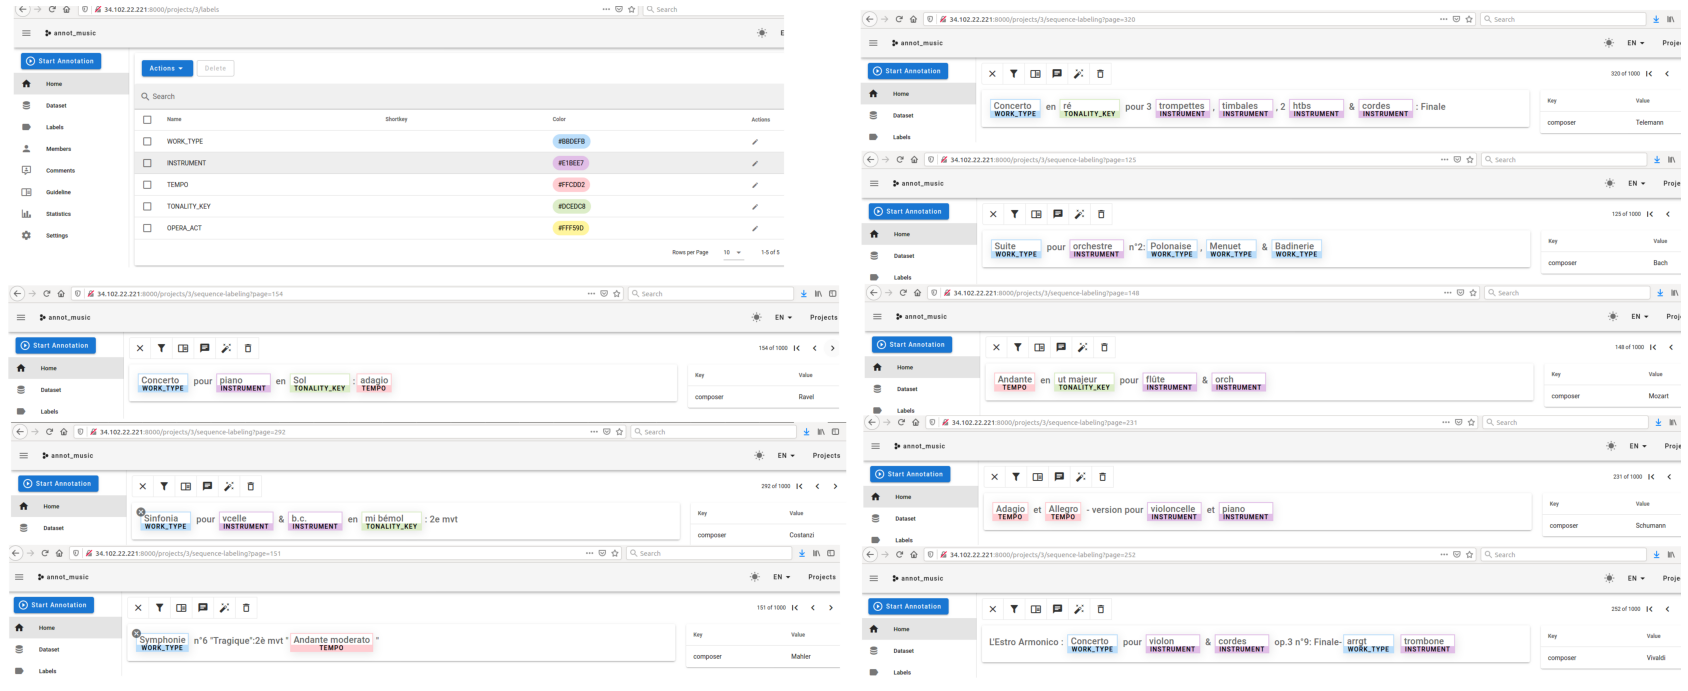

In [ ]:
im = pilim.open(os.environ["WORK_FOLDER"] + "SCR_DOCCANO_ANNOT.png")
fig,ax = plt.subplots(1,1, figsize = (30,15))
ax.imshow(im)
ax.axis("off");

In [ ]:
%%bash

cd "$WORK_FOLDER"

ls -al | grep ".zip"

unzip 355f6c56-fe5f-4450-beb7-1e08a89ec95b.zip -d annotated_dataset

echo "-------------------------------------------"
tree annotated_dataset

-rw------- 1 root root   28153 May 27 10:20 355f6c56-fe5f-4450-beb7-1e08a89ec95b.zip
Archive:  355f6c56-fe5f-4450-beb7-1e08a89ec95b.zip
  inflating: annotated_dataset/admin.jsonl  
  inflating: annotated_dataset/unknown.jsonl  
-------------------------------------------
annotated_dataset
├── admin.jsonl
└── unknown.jsonl

0 directories, 2 files


In [ ]:
!cat "$WORK_FOLDER/annotated_dataset/admin.jsonl" | wc -l

!head -c 600 "$WORK_FOLDER/annotated_dataset/admin.jsonl"

816
{"id": 2001, "data": "Concerto pour vcelle n°4:Allegro final", "label": [[0, 8, "WORK_TYPE"], [14, 20, "INSTRUMENT"], [25, 32, "TEMPO"]], "composer": "Boccherini"}
{"id": 2002, "data": "Partita pour clavier n°1: Gigue", "label": [[13, 20, "INSTRUMENT"], [26, 31, "WORK_TYPE"]], "composer": "Bach"}
{"id": 2003, "data": "Symphonie n°1: 2e mvt", "label": [[0, 9, "WORK_TYPE"]], "composer": "Gade"}
{"id": 2004, "data": "Symphonie n° 6 \"Tragique\" : 1er mvt", "label": [[0, 9, "WORK_TYPE"]], "composer": "Mahler"}
{"id": 2005, "data": "Concerto pour trombone & orch: 1er mvt", "label": [[0, 8, "WOR

## Format the dataset as expected by Spacy 


### For Spacy v2, using JQ

as a list of (L2) lists, each (L2) list having 2 elements, for example:

```
[ "Concerto pour vcelle n°4:Allegro final" ,
  { "entities" :
    [ 
        [0, 8, "WORK_TYPE"],
        [14, 20, "INSTRUMENT"],
        [25, 32, "TEMPO"]
    ]
  }
]
```

In [ ]:
%%bash

cd "$WORK_FOLDER/annotated_dataset/"

rm -f annot_intermed.json
rm -f annot_ready.json


#test in https://jqplay.org/

cat admin.jsonl | jq -c '. | [.data, {entities : .label}]  ' > annot_intermed.json


#convert jsonl (newline delimited) to json array 
cat annot_intermed.json | jq -s "." > annot_ready.json

#take first 600 entries as train set , last 216 as validation set
cat annot_ready.json | jq -s ".[0][0:600] " > annot_ready_train.json
cat annot_ready.json | jq -s ".[0][601:] " > annot_ready_valid.json


In [ ]:
!head -c 400 "$WORK_FOLDER/annotated_dataset/annot_intermed.json"

!echo ""
!echo "---------------------------------------------------------"

#!head -c 600 "$WORK_FOLDER/annotated_dataset/annot_ready.json"


!echo ""
!echo "---------------------------------------------------------"

!head -c 600 "$WORK_FOLDER/annotated_dataset/annot_ready_train.json"

!echo "---------------------------------------------------------"

!head -c 300 "$WORK_FOLDER/annotated_dataset/annot_ready_valid.json"


["Concerto pour vcelle n°4:Allegro final",{"entities":[[0,8,"WORK_TYPE"],[14,20,"INSTRUMENT"],[25,32,"TEMPO"]]}]
["Partita pour clavier n°1: Gigue",{"entities":[[13,20,"INSTRUMENT"],[26,31,"WORK_TYPE"]]}]
["Symphonie n°1: 2e mvt",{"entities":[[0,9,"WORK_TYPE"]]}]
["Symphonie n° 6 \"Tragique\" : 1er mvt",{"entities":[[0,9,"WORK_TYPE"]]}]
["Concerto pour trombone & orch: 1er mvt",{"entities":[[0
---------------------------------------------------------

---------------------------------------------------------
[
  [
    "Concerto pour vcelle n°4:Allegro final",
    {
      "entities": [
        [
          0,
          8,
          "WORK_TYPE"
        ],
        [
          14,
          20,
          "INSTRUMENT"
        ],
        [
          25,
          32,
          "TEMPO"
        ]
      ]
    }
  ],
  [
    "Partita pour clavier n°1: Gigue",
    {
      "entities": [
        [
          13,
          20,
          "INSTRUMENT"
        ],
        [
          26,
          31,
   

**Optionally, collect the list of distinct labels with pyjq:**

In [ ]:
with open(os.environ["WORK_FOLDER"] + "annotated_dataset/annot_ready.json") as f:
    data_json = json.load(f)

pp.pprint(data_json[1])
print("----------------------------------------------------")

#test it on https://jqplay.org/
#we get the second item of each list and from it we get the third item in each element in its entities field
list_labels = pyjq.all(".[][1] | .entities[][2]  ", data_json)

print(list_labels[0:5], " ...")

#now take unique
list_entities = list(set(list_labels))
print("----------------------------------------------------")

print("All entities annotated: \n", list_entities)

['Partita pour clavier n°1: Gigue', {'entities': [[13, 20, 'INSTRUMENT'], [26, 31, 'WORK_TYPE']]}]
----------------------------------------------------
['WORK_TYPE', 'INSTRUMENT', 'TEMPO', 'INSTRUMENT', 'WORK_TYPE']  ...
----------------------------------------------------
All entities annotated: 
 ['INSTRUMENT', 'TEMPO', 'WORK_TYPE', 'TONALITY_KEY', 'OPERA_ACT']


### For Spacy v3

In Spacy v3, a binary format is required, so we convert the above files

see:  
https://spacy.io/api/cli#convert  
https://stackoverflow.com/questions/64675654/spacy-bilou-format-to-spacy-json-format/64677899#64677899

In [ ]:
def convert_json_to_spacy(input_file):

    with open(input_file) as f:
        data_json = json.load(f)

    #nlp = spacy.blank("fr")
    nlp = spacy.load("fr_core_news_lg")
    nlp.tokenizer = custom_tokenizer(nlp)

    db = DocBin()

    for annot in data_json:
        #print(annot[0]," ||| ", annot[1])
        text = annot[0]
        entities = annot[1]
        example = Example.from_dict(nlp.make_doc(text), entities)
        db.add(example.reference)

    target_filename = input_file[:-len(".json")] + ".spacy"
    db.to_disk(target_filename)

In [ ]:
!rm -f "$WORK_FOLDER/annotated_dataset/annot_ready_"*.spacy

In [ ]:
convert_json_to_spacy(input_file = os.environ["WORK_FOLDER"] + "annotated_dataset/annot_ready_train.json")

print("--------------------------------------------------------------------")

convert_json_to_spacy(input_file = os.environ["WORK_FOLDER"] + "annotated_dataset/annot_ready_valid.json")


/usr/local/lib/python3.7/dist-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Blood and Sand (Arènes sanglantes) -BO film Rouben..." with entities "[[36, 43, 'WORK_TYPE']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/usr/local/lib/python3.7/dist-packages/spacy/training/iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "Sonate pour violon & piano K. 303: 2nd mvt "Tempo ..." with entities "[[0, 6, 'WORK_TYPE'], [12, 18, 'INSTRUMENT'], [21,...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
/usr/local/lib/python3.7/dist-packages/spacy/trainin

--------------------------------------------------------------------


In [ ]:
#load it to inspect what resulted in the above conversion
nlp_fr = spacy.blank("fr")


doc_bin = DocBin().from_disk(os.environ["WORK_FOLDER"] + "annotated_dataset/annot_ready_train.spacy")

utility_dir(doc_bin)

print("--------------------------------------------------")

print(doc_bin.attrs)

docs_aux = list(doc_bin.get_docs(nlp_fr.vocab))
print(len(docs_aux), "docs")


print(docs_aux[0], docs_aux[0].ents)

add     attrs      cats         flags            from_bytes  from_disk  get_docs
merge   spaces     span_groups  store_user_data  strings     to_bytes   to_disk
tokens  user_data  version
--------------------------------------------------
[65, 67, 73, 74, 75, 76, 77, 78, 79, 80, 452, 453, 454]
600 docs
Concerto pour vcelle n°4:Allegro final (Concerto, vcelle, Allegro)


----------------------------

----------------------------

## Prepare Spacy project

Introduced in Spacy v3

see   
https://spacy.io/usage/projects  
https://github.com/explosion/projects/tree/v3/pipelines/ner_demo

In [ ]:
!rm -r -f /content/ner_demo

In [ ]:
!python -m spacy project clone pipelines/ner_demo

2021-06-01 08:44:05.036402: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
✔ Cloned 'pipelines/ner_demo' from explosion/projects
/content/ner_demo
✔ Your project is now ready!
To fetch the assets, run:
python -m spacy project assets /content/ner_demo


Inspect was was cloned:

In [ ]:
%%bash

tree /content/ner_demo

/content/ner_demo
├── assets
│   ├── dev.json
│   └── train.json
├── project.yml
├── README.md
├── requirements.txt
├── scripts
│   ├── convert.py
│   └── visualize_model.py
└── test_project_ner_demo.py

2 directories, 8 files


In [ ]:
!cat /content/ner_demo/project.yml  

title: "Demo NER in a new pipeline (Named Entity Recognition)"
description: "A minimal demo NER project for spaCy v3 adapted from the spaCy v2 [`train_ner.py`](https://github.com/explosion/spaCy/blob/v2.3.x/examples/training/train_ner.py) example script for creating an NER component in a new pipeline."
# Variables can be referenced across the project.yml using ${vars.var_name}
vars:
  name: "ner_demo"
  lang: "en"
  train: "train.json"
  dev: "dev.json"
  version: "0.0.0"
  # Set your GPU ID, -1 is CPU
  gpu_id: -1
  # Vectors model for train-with-vectors
  vectors_model: "en_core_web_md"

# These are the directories that the project needs. The project CLI will make
# sure that they always exist.
directories: ["assets", "corpus", "configs", "training", "scripts", "packages"]

# Assets that should be downloaded or available in the directory. We're shipping
# them with the project, so they won't have to be downloaded.
assets:
  - dest: "assets/train.json"
    description: "Demo training 

We can parse the YAML file using YQ:

In [ ]:
#!yq --help

In [ ]:
#names of entries under "commands" key
!yq r /content/ner_demo/project.yml 'commands.*.name'

download
convert
create-config
train
train-with-vectors
evaluate
package
visualize-model


In [ ]:
#the assets section
!yq r /content/ner_demo/project.yml  'assets'

- dest: "assets/train.json"
  description: "Demo training data converted from the v2 `train_ner.py` example with `srsly.write_json(\"train.json\", TRAIN_DATA)`"
- dest: "assets/dev.json"
  description: "Demo development data"


In [ ]:
#the vars section
!yq r /content/ner_demo/project.yml 'vars' 

name: "ner_demo"
lang: "en"
train: "train.json"
dev: "dev.json"
version: "0.0.0"
# Set your GPU ID, -1 is CPU
gpu_id: -1
# Vectors model for train-with-vectors
vectors_model: "en_core_web_md"


###Make changes in the YAML file:

In [ ]:
%%bash
#replace inplace, preserving quotes
yq w -i /content/ner_demo/project.yml  'vars.lang' --tag '!!str' --style=double "fr"
yq w -i /content/ner_demo/project.yml  'vars.vectors_model' --tag '!!str' --style=double "fr_core_news_lg"

yq w -i /content/ner_demo/project.yml  'vars.train' --tag '!!str' --style=double  "annot_ready_train.json"
yq w -i /content/ner_demo/project.yml  'vars.dev' --tag '!!str' --style=double  "annot_ready_valid.json"

yq r /content/ner_demo/project.yml 'vars' 

name: "ner_demo"
lang: "fr"
train: "annot_ready_train.json"
dev: "annot_ready_valid.json"
version: "0.0.0"
# Set your GPU ID, -1 is CPU
gpu_id: -1
# Vectors model for train-with-vectors
vectors_model: "fr_core_news_lg"


In [ ]:
%%bash
#replace inplace, preserving quotes
yq w -i /content/ner_demo/project.yml  'assets[0].dest' --tag '!!str' --style=double "assets/annot_ready_train.json"
yq w -i /content/ner_demo/project.yml  'assets[1].dest' --tag '!!str' --style=double "assets/annot_ready_valid.json"

yq r /content/ner_demo/project.yml 'assets' 

- dest: "assets/annot_ready_train.json"
  description: "Demo training data converted from the v2 `train_ner.py` example with `srsly.write_json(\"train.json\", TRAIN_DATA)`"
- dest: "assets/annot_ready_valid.json"
  description: "Demo development data"


Now copy the two json files to the assets folder:

In [ ]:
%%bash

cd /content/ner_demo/assets/

rm *.json

cp "$WORK_FOLDER/annotated_dataset/annot_ready_train.json" .
cp "$WORK_FOLDER/annotated_dataset/annot_ready_valid.json" .

tree .

.
├── annot_ready_train.json
└── annot_ready_valid.json

0 directories, 2 files


------------------------------

### Generate Config file

In [ ]:
!rm -f /content/ner_demo/configs/config.cfg

In [ ]:
!cd /content/ner_demo/ && python -m spacy project run create-config

2021-06-01 08:45:19.403109: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

=============================== create-config ===============================
Running command: /usr/bin/python3 -m spacy init config --lang fr --pipeline ner configs/config.cfg --force
2021-06-01 08:45:22.006559: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
⚠ To generate a more effective transformer-based config (GPU-only),
install the spacy-transformers package and re-run this command. The config
generated now does not use transformers.
ℹ Generated config template specific for your use case
- Language: fr
- Pipeline: ner
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
configs/config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --path

In [ ]:
### inspect the generated file
!cat /content/ner_demo/configs/config.cfg

[paths]
train = null
dev = null
vectors = null
init_tok2vec = null

[system]
gpu_allocator = null
seed = 0

[nlp]
lang = "fr"
pipeline = ["tok2vec","ner"]
batch_size = 1000
disabled = []
before_creation = null
after_creation = null
after_pipeline_creation = null
tokenizer = {"@tokenizers":"spacy.Tokenizer.v1"}

[components]

[components.ner]
factory = "ner"
moves = null
update_with_oracle_cut_size = 100

[components.ner.model]
@architectures = "spacy.TransitionBasedParser.v2"
state_type = "ner"
extra_state_tokens = false
hidden_width = 64
maxout_pieces = 2
use_upper = true
nO = null

[components.ner.model.tok2vec]
@architectures = "spacy.Tok2VecListener.v1"
width = ${components.tok2vec.model.encode.width}
upstream = "*"

[components.tok2vec]
factory = "tok2vec"

[components.tok2vec.model]
@architectures = "spacy.Tok2Vec.v2"

[components.tok2vec.model.embed]
@architectures = "spacy.MultiHashEmbed.v2"
width = ${components.tok2vec.model.encode.width}
attrs = ["NORM","PREFIX","SUFFIX","SHA

-------------------------

### Customize the tokenizer in the training config



**SCRIPT TO BE USED AT TRAIN TIME**

see https://spacy.io/usage/training#custom-tokenizer

We must write the code in a script file:

In [ ]:
%%writefile /content/ner_demo/scripts/customfct.py

from spacy.util import registry
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

@registry.callbacks("customize_tokenizer")
def make_customize_tokenizer():

    #below is the code we uused in a previous section

    def custom_tokenizer(nlp):
        
        infixes = nlp.Defaults.infixes + [
                        r':',
                        r'(?<=[\d])\-(?=[A-Za-z])',
                        r'(?<=[A-Za-z0-9])\"\)?\-?(?=[A-Za-z])', 
                        r'(?<=[A-Za-z0-9])\"?\)?\-(?=[A-Za-z])', 
                ]
        infix_re = compile_infix_regex(infixes)

        prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
        suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

        tknz = Tokenizer(nlp.vocab, 
                        prefix_search = prefix_re.search,
                        suffix_search = suffix_re.search,
                        infix_finditer = infix_re.finditer,
                        token_match = nlp.tokenizer.token_match,
                        rules = nlp.Defaults.tokenizer_exceptions)  
        
        nlp.tokenizer = tknz

    return custom_tokenizer  

Writing /content/ner_demo/scripts/customfct.py


**MODIFY CONFIG.CFG FILE TO USE IT**

In [ ]:
%%bash

#remove the entry:  before_init = null  under [initialize]
#note: config.cfg is not yaml, so we use sed for inplace replacement
sed -i 's/before_init = null/ /' /content/ner_demo/configs/config.cfg  


#and append this section

cat <<EOT >> /content/ner_demo/configs/config.cfg


[initialize.before_init]
@callbacks = "customize_tokenizer"
EOT


In [ ]:
!tail -15 /content/ner_demo/configs/config.cfg


[initialize]
vectors = null
init_tok2vec = ${paths.init_tok2vec}
vocab_data = null
lookups = null
 
after_init = null

[initialize.components]

[initialize.tokenizer]

[initialize.before_init]
@callbacks = "customize_tokenizer"


**MODIFY PROJECT.YAML TO USE IT**

In [ ]:
#read the entry with name train under commands
!yq r /content/ner_demo/project.yml  'commands.(name==train)'

name: "train"
help: "Train the NER model"
script:
  - "python -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id ${vars.gpu_id}"
deps:
  - "configs/config.cfg"
  - "corpus/train.spacy"
  - "corpus/dev.spacy"
outputs:
  - "training/model-best"


In [ ]:
#read the entry with name train-with-vectors under commands
!yq r /content/ner_demo/project.yml  'commands.(name==train-with-vectors)'

name: "train-with-vectors"
help: "Train the NER model with vectors"
script:
  - "python -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id ${vars.gpu_id} --initialize.vectors ${vars.vectors_model} --components.tok2vec.model.embed.include_static_vectors true"
deps:
  - "configs/config.cfg"
  - "corpus/train.spacy"
  - "corpus/dev.spacy"
outputs:
  - "training/model-best"


In [ ]:
%%bash
#include --code scripts/customfct.py  at the end 

yq w -i /content/ner_demo/project.yml  'commands.(name==train).script[0]' \
   --tag '!!str' --style=double \
   "python -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id \${vars.gpu_id} --code scripts/customfct.py"


yq w -i /content/ner_demo/project.yml  'commands.(name==train-with-vectors).script[0]' \
   --tag '!!str' --style=double \
   "python -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id \${vars.gpu_id} --initialize.vectors \${vars.vectors_model} --components.tok2vec.model.embed.include_static_vectors true --code scripts/customfct.py"


#add to deps

yq w -i /content/ner_demo/project.yml  'commands.(name==train).deps[+]' \
   --tag '!!str' --style=double \
   "scripts/customfct.py"

yq w -i /content/ner_demo/project.yml  'commands.(name==train-with-vectors).deps[+]' \
   --tag '!!str' --style=double \
   "scripts/customfct.py"

In [ ]:
!yq r /content/ner_demo/project.yml  'commands.(name==train)'

name: "train"
help: "Train the NER model"
script:
  - "python -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id ${vars.gpu_id} --code scripts/customfct.py"
deps:
  - "configs/config.cfg"
  - "corpus/train.spacy"
  - "corpus/dev.spacy"
  - "scripts/customfct.py"
outputs:
  - "training/model-best"


In [ ]:
#read the entry with name train-with-vectors under commands
!yq r /content/ner_demo/project.yml  'commands.(name==train-with-vectors)'

name: "train-with-vectors"
help: "Train the NER model with vectors"
script:
  - "python -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id ${vars.gpu_id} --initialize.vectors ${vars.vectors_model} --components.tok2vec.model.embed.include_static_vectors true --code scripts/customfct.py"
deps:
  - "configs/config.cfg"
  - "corpus/train.spacy"
  - "corpus/dev.spacy"
  - "scripts/customfct.py"
outputs:
  - "training/model-best"


------------------------------------------

### Customize the tokenizer in the Converter

In [ ]:
#initially was
!cat /content/ner_demo/scripts/convert.py

"""Convert entity annotation from spaCy v2 TRAIN_DATA format to spaCy v3
.spacy format."""
import srsly
import typer
import warnings
from pathlib import Path

import spacy
from spacy.tokens import DocBin


def convert(lang: str, input_path: Path, output_path: Path):
    nlp = spacy.blank(lang)
    db = DocBin()
    for text, annot in srsly.read_json(input_path):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label)
            if span is None:
                msg = f"Skipping entity [{start}, {end}, {label}] in the following text because the character span '{doc.text[start:end]}' does not align with token boundaries:\n\n{repr(text)}\n"
                warnings.warn(msg)
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    db.to_disk(output_path)


if __name__ == "__main__":
    typer.run(convert)


In [ ]:
%%writefile /content/ner_demo/scripts/convert_custom.py

"""Convert entity annotation from spaCy v2 TRAIN_DATA format to spaCy v3
.spacy format."""
import srsly
import typer
import warnings
from pathlib import Path

import spacy
from spacy.tokens import DocBin
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex

def custom_tokenizer(nlp):
    infixes = nlp.Defaults.infixes + [
                        r':',
                        r'(?<=[\d])\-(?=[A-Za-z])',
                        r'(?<=[A-Za-z0-9])\"\)?\-?(?=[A-Za-z])', 
                        r'(?<=[A-Za-z0-9])\"?\)?\-(?=[A-Za-z])', 
                ]
    infix_re = compile_infix_regex(infixes)

    prefix_re = compile_prefix_regex(nlp.Defaults.prefixes)
    suffix_re = compile_suffix_regex(nlp.Defaults.suffixes)

    tknz = Tokenizer(nlp.vocab, 
                    prefix_search = prefix_re.search,
                    suffix_search = suffix_re.search,
                    infix_finditer = infix_re.finditer,
                    token_match = nlp.tokenizer.token_match,
                    rules = nlp.Defaults.tokenizer_exceptions) 
    return tknz 
    
#--------------------------------------------------------------------

def convert(lang: str, input_path: Path, output_path: Path):
    nlp = spacy.load(lang)
    db = DocBin()

    nlp.tokenizer = custom_tokenizer(nlp)

    for text, annot in srsly.read_json(input_path):
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label)
            if span is None:
                msg = f"Skipping entity [{start}, {end}, {label}] in the following text because the character span '{doc.text[start:end]}' does not align with token boundaries:\n\n{repr(text)}\n"
                warnings.warn(msg)
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)
    db.to_disk(output_path)


if __name__ == "__main__":
    typer.run(convert)

Writing /content/ner_demo/scripts/convert_custom.py


**MODIFY PROJECT.YAML FILE TO USE IT**

In [ ]:
!yq r /content/ner_demo/project.yml  'commands.(name==convert)'

name: "convert"
help: "Convert the data to spaCy's binary format"
script:
  - "python scripts/convert.py ${vars.lang} assets/${vars.train} corpus/train.spacy"
  - "python scripts/convert.py ${vars.lang} assets/${vars.dev} corpus/dev.spacy"
deps:
  - "assets/${vars.train}"
  - "assets/${vars.dev}"
  - "scripts/convert.py"
outputs:
  - "corpus/train.spacy"
  - "corpus/dev.spacy"


In [ ]:
!yq r /content/ner_demo/project.yml  'commands.(name==convert).script[0]'
!yq r /content/ner_demo/project.yml  'commands.(name==convert).script[1]'
!yq r /content/ner_demo/project.yml  'commands.(name==convert).deps[-1]'

python scripts/convert.py ${vars.lang} assets/${vars.train} corpus/train.spacy
python scripts/convert.py ${vars.lang} assets/${vars.dev} corpus/dev.spacy
scripts/convert.py


In [ ]:
%%bash

#replace inplace, preserving quotes
yq w -i /content/ner_demo/project.yml  'commands.(name==convert).script[0]' \
     --tag '!!str' --style=double \
     "python scripts/convert_custom.py \${vars.vectors_model} assets/\${vars.train} corpus/train.spacy"


yq w -i /content/ner_demo/project.yml  'commands.(name==convert).script[1]' \
     --tag '!!str' --style=double \
     "python scripts/convert_custom.py \${vars.vectors_model} assets/\${vars.dev} corpus/dev.spacy"


yq w -i /content/ner_demo/project.yml  'commands.(name==convert).deps[-1]' \
     --tag '!!str' --style=double \
     "scripts/convert_custom.py"

In [ ]:
!yq r /content/ner_demo/project.yml  'commands.(name==convert)'

name: "convert"
help: "Convert the data to spaCy's binary format"
script:
  - "python scripts/convert_custom.py ${vars.vectors_model} assets/${vars.train} corpus/train.spacy"
  - "python scripts/convert_custom.py ${vars.vectors_model} assets/${vars.dev} corpus/dev.spacy"
deps:
  - "assets/${vars.train}"
  - "assets/${vars.dev}"
  - "scripts/convert_custom.py"
outputs:
  - "corpus/train.spacy"
  - "corpus/dev.spacy"


-----------------------------------

##Run steps of the Spacy project's workflow:

### Ensure assets are ok

In [ ]:
!cd /content/ner_demo/ && python -m spacy project assets

2021-06-01 08:46:20.375865: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
ℹ Fetching 2 asset(s)
✔ Asset already exists:
/content/ner_demo/assets/annot_ready_train.json
✔ Asset already exists:
/content/ner_demo/assets/annot_ready_valid.json


### Convert datafile from JSON to binary Spacy v3 format

In [ ]:
!rm -f /content/ner_demo/corpus/*

In [ ]:
!cd /content/ner_demo/ && python -m spacy project run convert

2021-06-01 08:46:37.417630: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

================================== convert ==================================
Running command: /usr/bin/python3 scripts/convert_custom.py fr_core_news_lg assets/annot_ready_train.json corpus/train.spacy
2021-06-01 08:46:40.047797: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
scripts/convert_custom.py:49: UserWarning: Skipping entity [36, 43, WORK_TYPE] in the following text because the character span 'BO film' does not align with token boundaries:

'Blood and Sand (Arènes sanglantes) -BO film Rouben Mamoulian (1941)'

  warnings.warn(msg)
scripts/convert_custom.py:49: UserWarning: Skipping entity [44, 61, TEMPO] in the following text because the character span 'Tempo di Menuetto' does not align with token boundaries:

'Sonate pour violon & piano K. 303: 2nd mvt "Tempo d

In [ ]:
!tree  --du -h /content/ner_demo/corpus

/content/ner_demo/corpus
├── [ 17K]  dev.spacy
└── [ 43K]  train.spacy

  64K used in 0 directories, 2 files


### Debug data

Note that it uses solely the config.cfg (without project.yaml)   

see https://spacy.io/api/cli#debug-data

In [ ]:
%%bash

cd /content/ner_demo

python -m spacy debug data configs/config.cfg \
  --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy \
  --code scripts/customfct.py


============================ Data file validation ============================
✔ Corpus is loadable
✔ Pipeline can be initialized with data

=============================== Training stats ===============================
Language: fr
Training pipeline: tok2vec, ner
600 training docs
215 evaluation docs
⚠ 3 training examples also in evaluation data
⚠ Low number of examples to train a new pipeline (600)

============================== Vocab & Vectors ==============================
ℹ 5022 total word(s) in the data (1185 unique)
⚠ 48 misaligned tokens in the training data
⚠ 27 misaligned tokens in the dev data
ℹ No word vectors present in the package

========================== Named Entity Recognition ==========================
ℹ 5 label(s)
0 missing value(s) (tokens with '-' label)
⚠ 5 entity span(s) with punctuation
⚠ Low number of examples for label 'OPERA_ACT' (36)
⚠ Low number of examples for label 'TONALITY_KEY' (23)
⚠ Low number of examples for label 'TEMPO' (33)
✔ Examples without

2021-06-01 08:51:00.787688: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


**Check if balanced labels between datasets**

In [ ]:
#recap how data is structured in json
!head -c 500 /content/ner_demo/assets/annot_ready_train.json

[
  [
    "Concerto pour vcelle n°4:Allegro final",
    {
      "entities": [
        [
          0,
          8,
          "WORK_TYPE"
        ],
        [
          14,
          20,
          "INSTRUMENT"
        ],
        [
          25,
          32,
          "TEMPO"
        ]
      ]
    }
  ],
  [
    "Partita pour clavier n°1: Gigue",
    {
      "entities": [
        [
          13,
          20,
          "INSTRUMENT"
        ],
        [
          26,
          31,
          "WORK

In [ ]:
%%bash

cd /content/ner_demo/assets/

declare -a arr=("INSTRUMENT" 
                "WORK_TYPE"
                "TEMPO" 
                "TONALITY_KEY" 
                "OPERA_ACT"
                )

#left justify strings in bash
printf  "%-20s | %-20s | %-20s\n" "LABEL" "TRAINSET" "VALIDATION"
echo "========================================================================"

for lab in "${arr[@]}"
do

# jq -s '.[][] | ...'   or   jq -r '.[] | ...'
# .[][] | last  extracts the "entities" of all items ==> {"entities" : [...]} {"entities" : [...]} {"entities" : [...]} 
# .[][] | last | select(.entities[] | index("INSTRUMENT"))  filters the above to kep only those with at least one INSTRUMENT annot ==> idem 
#wrap everything into a [ ... ] and apply length to count elements 

num_examples_train=$(cat annot_ready_train.json | jq -s "[ .[][] | last |  select(.entities[] | index(\"$lab\")) ] | length")
num_examples_valid=$(cat annot_ready_valid.json | jq -s "[ .[][] | last |  select(.entities[] | index(\"$lab\")) ] | length")

total=$(( num_examples_train + num_examples_valid))
perc_train=$(( 100 * num_examples_train/total ))
perc_valid=$(( 100 * num_examples_valid/total ))


printf  "%-20s | %-12s (%-3s %%) | %-12s (%-3s %%) \n" "$lab" "$num_examples_train" "$perc_train" "$num_examples_valid" "$perc_valid"

done



LABEL                | TRAINSET             | VALIDATION          
INSTRUMENT           | 471          (70  %) | 198          (29  %) 
WORK_TYPE            | 626          (72  %) | 234          (27  %) 
TEMPO                | 35           (81  %) | 8            (18  %) 
TONALITY_KEY         | 23           (82  %) | 5            (17  %) 
OPERA_ACT            | 37           (78  %) | 10           (21  %) 


### Debug Thinc model

In [ ]:
%%bash

cd /content/ner_demo

python -m spacy debug model configs/config.cfg ner --print-step0

ℹ Using CPU
ℹ Fixing random seed: 0
ℹ Analysing model with ID 66

========================== STEP 0 - before training ==========================
ℹ Layer 0: model ID 66: 'parser_model'
ℹ Layer 1: model ID 63: 'tok2vec-listener>>list2array>>linear'
ℹ Layer 2: model ID 64: 'precomputable_affine'
ℹ Layer 3: model ID 65: 'linear'
ℹ Layer 4: model ID 60: 'tok2vec-listener'
ℹ Layer 5: model ID 61: 'list2array'
ℹ Layer 6: model ID 62: 'linear'

✘ Could not initialize the model: you'll have to provide a valid
train_corpus argument in the config file.



2021-06-01 09:30:46.598948: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


### Train - version 1

In [ ]:
!tree /content/ner_demo/

/content/ner_demo/
├── assets
│   ├── annot_ready_train.json
│   └── annot_ready_valid.json
├── configs
│   └── config.cfg
├── corpus
│   ├── dev.spacy
│   └── train.spacy
├── packages
├── project.lock
├── project.yml
├── README.md
├── requirements.txt
├── scripts
│   ├── convert_custom.py
│   ├── convert.py
│   ├── customfct.py
│   ├── __pycache__
│   │   └── customfct.cpython-37.pyc
│   └── visualize_model.py
├── test_project_ner_demo.py
└── training

7 directories, 15 files


In [ ]:
!cd /content/ner_demo/ && python -m spacy project run train

2021-06-01 10:37:42.512244: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

=================================== train ===================================
Running command: /usr/bin/python3 -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id -1 --code scripts/customfct.py
2021-06-01 10:37:45.092805: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2021-06-01 10:37:51,104] [INFO] Set up nlp object from config
[2021-06-01 10:37:51,114] [INFO] Pipeline: ['tok2vec', 'ner']
[2021-06-01 10:37:51,174] [INFO] Created vocabulary
[2021-06-01 10:37:51,174] [INFO] Finished initializing nlp object
[2021-06-01 10:37:51,818] [INFO] Initialized pipeline 

In [ ]:
#generated artefacts
!tree --du -h /content/ner_demo/training

/content/ner_demo/training
├── [7.9M]  model-best
│   ├── [2.5K]  config.cfg
│   ├── [1.2K]  meta.json
│   ├── [133K]  ner
│   │   ├── [ 191]  cfg
│   │   ├── [129K]  model
│   │   └── [ 366]  moves
│   ├── [6.3M]  tok2vec
│   │   ├── [   4]  cfg
│   │   └── [6.3M]  model
│   ├── [1.4M]  tokenizer
│   └── [ 43K]  vocab
│       ├── [   1]  key2row
│       ├── [   1]  lookups.bin
│       ├── [ 39K]  strings.json
│       └── [ 128]  vectors
└── [7.9M]  model-last
    ├── [2.5K]  config.cfg
    ├── [1.2K]  meta.json
    ├── [133K]  ner
    │   ├── [ 191]  cfg
    │   ├── [129K]  model
    │   └── [ 366]  moves
    ├── [6.3M]  tok2vec
    │   ├── [   4]  cfg
    │   └── [6.3M]  model
    ├── [1.4M]  tokenizer
    └── [ 43K]  vocab
        ├── [   1]  key2row
        ├── [   1]  lookups.bin
        ├── [ 39K]  strings.json
        └── [ 128]  vectors

  16M used in 8 directories, 24 files


In [ ]:
!cd /content/ner_demo/ && python -m spacy project run evaluate

2021-06-01 10:39:40.371359: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

================================== evaluate ==================================
Running command: /usr/bin/python3 -m spacy evaluate training/model-best corpus/dev.spacy --output training/metrics.json
2021-06-01 10:39:42.909471: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
ℹ Using CPU

================================== Results ==================================

TOK     100.00
NER P   92.87 
NER R   91.65 
NER F   92.26 
SPEED   8068  


=============================== NER (per type) ===============================

                   P        R       F
WORK_TYPE      92.61    91.03   91.81
INSTRUMENT     96.39    94.44   95.41
OPERA_ACT      76.92   100.00   86.96
TEMPO          50.00    50.00   50.00
TONALITY_KEY   75.00    60.00   66.67

✔ Saved results to training/me

In [ ]:
#move to v1
!mv /content/ner_demo/training  /content/ner_demo/training_v1

### Train - version 2

In this experiment we use `--initialize.vectors fr_core_news_lg --components.tok2vec.model.embed.include_static_vectors true`

In [ ]:
!mkdir -p /content/ner_demo/training

In [ ]:
!cd /content/ner_demo/ && python -m spacy project run train-with-vectors

2021-06-01 10:40:18.698626: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

============================= train-with-vectors =============================
Running command: /usr/bin/python3 -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id -1 --initialize.vectors fr_core_news_lg --components.tok2vec.model.embed.include_static_vectors true --code scripts/customfct.py
2021-06-01 10:40:21.253834: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2021-06-01 10:40:27,206] [INFO] Set up nlp object from config
[2021-06-01 10:40:27,216] [INFO] Pipeline: ['tok2vec', 'ner']
[2021-06-01 10:40:27,276] [INFO] Created vocabulary
[2021-06-01 10:40:29,

In [ ]:
#generated artefacts
!tree --du -h /content/ner_demo/training

/content/ner_demo/training
├── [594M]  model-best
│   ├── [2.5K]  config.cfg
│   ├── [1.2K]  meta.json
│   ├── [133K]  ner
│   │   ├── [ 191]  cfg
│   │   ├── [129K]  model
│   │   └── [ 366]  moves
│   ├── [6.5M]  tok2vec
│   │   ├── [   4]  cfg
│   │   └── [6.5M]  model
│   ├── [1.4M]  tokenizer
│   └── [586M]  vocab
│       ├── [6.5M]  key2row
│       ├── [   1]  lookups.bin
│       ├── [7.1M]  strings.json
│       └── [572M]  vectors
└── [594M]  model-last
    ├── [2.5K]  config.cfg
    ├── [1.2K]  meta.json
    ├── [133K]  ner
    │   ├── [ 191]  cfg
    │   ├── [129K]  model
    │   └── [ 366]  moves
    ├── [6.5M]  tok2vec
    │   ├── [   4]  cfg
    │   └── [6.5M]  model
    ├── [1.4M]  tokenizer
    └── [586M]  vocab
        ├── [6.5M]  key2row
        ├── [   1]  lookups.bin
        ├── [7.1M]  strings.json
        └── [572M]  vectors

 1.2G used in 8 directories, 24 files


In [ ]:
!cd /content/ner_demo/ && python -m spacy project run evaluate

2021-06-01 10:46:49.873195: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

================================== evaluate ==================================
Running command: /usr/bin/python3 -m spacy evaluate training/model-best corpus/dev.spacy --output training/metrics.json
2021-06-01 10:46:57.218674: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
ℹ Using CPU

================================== Results ==================================

TOK     100.00
NER P   93.74 
NER R   92.09 
NER F   92.90 
SPEED   7155  


=============================== NER (per type) ===============================

                    P        R        F
WORK_TYPE       92.17    90.60    91.38
INSTRUMENT      97.42    95.45    96.43
OPERA_ACT       71.43   100.00    83.33
TEMPO           75.00    37.50    50.00
TONALITY_KEY   100.00   100.00   100.00

✔ Saved results to

In [ ]:
#move to v2
!mv /content/ner_demo/training  /content/ner_demo/training_v2

### Train - version 3

In this experiment we use `--initialize.vectors custom_model_word2vec_ext.model/ --components.tok2vec.model.embed.include_static_vectors true`  with Word2Vec embeddings trained with Gensim 

In [ ]:
!mkdir -p /content/ner_demo/training

#### Custom word vectors with Gensim

In [ ]:
df_composers_tracks_dedup = pd.read_json(os.environ["WORK_FOLDER"] + "composers_tracks_dedup.json", orient = "records")

df_aux = df_composers_tracks_dedup.sample(5)
df_aux

,code,duration_ms,composer,title
14548,21,469624,Haydn,"Symphonie n°48 ""Marie-Thérèse"": 1er mvt"
30516,21,204093,Albeniz,Malaguena - arrgt violon et piano (Kreisler)
13883,22,262491,Lehár,Rosenstock und Edelweissl:ouverture
30457,21,206663,Hahn,"L'Ile du rêve: Duo ""Jalouse!..."" (Finale Acte 2)"
37549,21,265416,Zarebski,"""Les roses et les épines"": Finale"


In [ ]:
#how it works
df_composers_tracks_dedup["title"].head(10).apply(lambda x: [(tok.lemma_.lower(), tok.pos_) 
                                                    for tok in nlp_pretrained(x) if tok.pos_ not in ["PUNCT", "NUM"]])

0    [(le, DET), (lac, NOUN), (de, ADP), (cygne, NOUN), (valse, NOUN)]                                        
1    [(le, DET), (chant, NOUN), (de, ADP), (partisan, NOUN)]                                                  
2    [(tristan, PROPN), (et, CCONJ), (isolde, PROPN), (prélude, NOUN)]                                        
3    [(le, DET), (marteau, PROPN), (sans, ADP), (maître, NOUN)]                                               
4    [(pulcinella, PROPN), (sinfonia, PROPN), (de, ADP), (ouverture, NOUN)]                                   
5    [(symphonie, NOUN), (numéro, NOUN), (mvt, VERB)]                                                         
6    [(lettre, NOUN), (à, ADP), (elise, PROPN)]                                                               
7    [(sonate, PROPN), (pour, ADP), (piano, NOUN), (k., PROPN), (troisième, ADJ), (mvt, VERB), (finale, NOUN)]
8    [(symphonie, NOUN), (numéro, NOUN), (italien, NOUN), (premier, ADJ), (mvt, VERB)]                        
9

In [ ]:
#we opt to perform text normaization (lemmatization, lowercase), but its consequences will be seen later on
df_composers_tracks_dedup["title_preproc"] = df_composers_tracks_dedup["title"].apply(lambda x: 
                                                 [tok.lemma_.lower() for tok in nlp_pretrained_2(x) 
                                                     if tok.pos_ not in ["PUNCT", "NUM"] and bool(re.search(r'\d', tok.text)) is False
                                                  ])
df_composers_tracks_dedup.iloc[df_aux.index]

,code,duration_ms,composer,title,title_preproc
14548,21,469624,Haydn,"Symphonie n°48 ""Marie-Thérèse"": 1er mvt","[symphonie, numéro, marie-thérèse, mvt]"
30516,21,204093,Albeniz,Malaguena - arrgt violon et piano (Kreisler),"[malaguena, arrgt, violon, et, piano, kreisler]"
13883,22,262491,Lehár,Rosenstock und Edelweissl:ouverture,"[rosenstock, edelweissl, ouverture]"
30457,21,206663,Hahn,"L'Ile du rêve: Duo ""Jalouse!..."" (Finale Acte 2)","[le, ile, de, rêve, duo, jalouse, finale, acte]"
37549,21,265416,Zarebski,"""Les roses et les épines"": Finale","[le, rose, et, le, épine, finale]"


In [ ]:
list_tokenized_titles = list(df_composers_tracks_dedup["title_preproc"].values)
pp.pprint(list_tokenized_titles[df_aux.index[0]:df_aux.index[0]+5])

[['symphonie', 'numéro', 'marie-thérèse', 'mvt'], ['symphonie', 'en', 'ré', 'mvt'], ['symphonie', 'en', 'ré', 'finale'],
 ['pièce', 'romantique', 'canzonetta'], ['pièce', 'romantique', 'intermezzo']]


In [ ]:
#help(gensim.models.Word2Vec.__init__)

In [ ]:
%%time
model_w2v = gensim.models.Word2Vec(sentences = list_tokenized_titles, 
                                   vector_size=32, sg = 1,
                                   min_count=1, 
                                   window=3,
                                   epochs = 100, seed = 100)

CPU times: user 54.6 s, sys: 299 ms, total: 54.9 s
Wall time: 30.7 s


In [ ]:
utility_dir(model_w2v.wv)
print("----------------------------------------------")

try:
    utility_dir(model_w2v.wv.vocab)
except Exception as e:
    print(e)

add_lifecycle_event  add_vector                 add_vectors                 allocate_vecattrs      closer_than             cosine_similarities           distance
distances            doesnt_match               evaluate_word_analogies     evaluate_word_pairs    expandos                fill_norms                    get_index
get_normed_vectors   get_vecattr                get_vector                  has_index_for          index2entity            index2word                    index_to_key
init_sims            intersect_word2vec_format  key_to_index                load                   load_word2vec_format    log_accuracy                  log_evaluate_word_pairs
mapfile_path         most_similar               most_similar_cosmul         most_similar_to_given  n_similarity            next_index                    norms
rank                 rank_by_centrality         relative_cosine_similarity  resize_vectors         save                    save_word2vec_format          set_vecattr
similar_

**INSPECT THE VOCABULARY**

In [ ]:
#vocabulary size
vocab = model_w2v.wv.key_to_index
print(type(vocab))

list_keys = sorted(list(vocab.keys()))
print(len(list_keys), " keys in vocab")
print("Example:")
utility_print_lists_columnized(list_keys[0:100], num_cols_columnize=10)

<class 'dict'>
14202  keys in vocab
Example:
                                             "a          "adagio    "agitata     "ah       "allegro       "alors
"amant    "boffon      "brindisi  "canto     "coeur      "comptine  "danse       "ecco     "fallt         "fammi
"formon   "gaiement    "gott      "i         "ich        "j         "la          "le       "mazeppa       "monstre
"mort     "omaggio     "piango    "pourquoi  "recondita  "romance   "rossignols  "régnez   "réjouissance  "saper
"schlafe  "sempr       "sento     "siam      "sposa      "tanti     "the         "thou     "tristes       "um
"una      "vicino      "vorresti  "vous      "warum      #          '            (air      (quintette     ):
-         -air         -arr       -arrgt     -bo         -bo-       -c.          -ce       -choeur        -mus
-slaves   -t           -the       -trio      -vou        /          :d           :o        =              _
a         a.           a.balsom   a.chabod   a.cuaron    a.dick

In [ ]:
model_w2v.wv["concerto"]

array([ 0.2610335 ,  0.5478306 , -0.43568775,  0.1780991 , -0.7502096 ,
        0.6763072 , -1.2243681 ,  1.029338  ,  0.3779181 ,  0.5431929 ,
        0.37310925,  1.4827013 , -1.5456454 ,  0.6000948 ,  0.43912646,
       -0.01105822,  0.4672538 ,  0.39603132, -0.4653071 , -0.49531344,
        0.9783742 ,  1.7504503 , -0.8503621 ,  0.3939872 ,  0.19543898,
        0.05166765, -1.0674119 , -1.0787009 ,  0.75712854, -0.74482757,
        0.8108827 ,  0.7057627 ], dtype=float32)

In [ ]:
model_w2v.wv.most_similar("concerto")

[('cto', 0.8890261054039001),
 ('mogul', 0.8026833534240723),
 ('concertone', 0.8016411662101746),
 ('gimo', 0.8000350594520569),
 ('abendstimmung', 0.7932891249656677),
 ('teresa', 0.7905591130256653),
 ('romani', 0.788016676902771),
 ('organizatt', 0.7852859497070312),
 ('dwd', 0.7850569486618042),
 ('concetto', 0.7816743850708008)]

In [ ]:
model_w2v.wv.most_similar("clavier")

[('quatuors', 0.7819429039955139),
 ('claviier', 0.7626877427101135),
 ('bc', 0.7609512209892273),
 ('mieur', 0.7536773085594177),
 ('clav', 0.7525208592414856),
 ('gracieusement', 0.7469322085380554),
 ('cpe', 0.7447503805160522),
 ('rondeaux', 0.7439507246017456),
 ('orgue', 0.743381917476654),
 ('anh', 0.7402930855751038)]

In [ ]:
model_w2v.wv.most_similar("sol")

[('ré', 0.8822351098060608),
 ('fa', 0.878402590751648),
 ('ut', 0.8130187392234802),
 ('toccata', 0.7876578569412231),
 ('op.posth', 0.785609781742096),
 ('v.musett', 0.7793203592300415),
 ('mineur', 0.774156391620636),
 ('iv.divertissement', 0.7692031264305115),
 ('allegramente', 0.7425856590270996),
 ('obliger', 0.7402245402336121)]

In [ ]:
model_w2v.wv.most_similar("andante")

[('andant', 0.7970432043075562),
 ('k.', 0.774198591709137),
 ('molto', 0.769618809223175),
 ('allegretto', 0.7656307816505432),
 ('mvt', 0.7636803388595581),
 ('allegro', 0.7635920643806458),
 ('espressivo', 0.7612677812576294),
 ('rondo', 0.7487062811851501),
 ('numéro', 0.7451460361480713),
 ('cantabile', 0.7414021492004395)]

We are satisfied with these vectors, so we save the word2vec model

**Save Word2Vec model:**

In [ ]:
model_w2v.wv.save_word2vec_format(os.environ["WORK_FOLDER"] + "model_word2vec.txt")

In [ ]:
model_w2v.wv.save(os.environ["WORK_FOLDER"] + "model_word2vec.bin")

In [ ]:
!du -h "$WORK_FOLDER/"model_word2vec.*

2.2M	/content/gdrive/My Drive/classicmusic_radio//model_word2vec.bin
5.0M	/content/gdrive/My Drive/classicmusic_radio//model_word2vec.txt


In [ ]:
!head -c 1500 "/content/gdrive/My Drive/classicmusic_radio/model_word2vec.txt"

14202 32
numéro 0.70300734 0.9655522 -0.38191542 -0.42945808 -0.6935537 0.41400346 0.18076468 0.22534977 0.012301642 0.94357216 0.37710974 1.1054657 -0.63326716 0.16326281 0.4928968 0.10105915 0.0837549 0.29180977 -0.50558716 -0.57974994 0.60174847 1.1016561 0.32277802 -0.59557897 -1.1895316 0.46970305 -0.3797567 -0.49993312 0.9382637 -0.67357475 0.29487705 0.6646518
pour 0.7341353 0.8087477 -0.42455336 -0.0032933874 -0.6268793 0.26977015 -0.34321436 0.3205765 0.39936164 0.8477243 -0.3856842 1.0112648 -0.23209591 0.13929112 -0.03396973 0.11685033 0.32613304 0.4953466 -0.44873053 0.2580778 0.88654417 1.1439359 0.512916 -0.27893868 -0.52897656 0.3678437 -0.32513696 -0.9307921 0.8453905 -0.50617504 0.089088514 0.60401106
et 0.80794644 0.4124935 0.19238207 0.16147353 -0.47678387 0.06477341 -0.29792386 0.273899 1.0227503 0.3747509 -0.35605597 0.6568629 -0.012009371 -0.085786864 -0.2944944 0.461552 0.43189204 0.6436443 -0.4004705 -0.06421903 0.6348476 0.89330786 0.3133739 0.0585273 -0.344539

So we have 14202 vectors of dimension 32

#### Initialize a Spacy model with vectors produced by Word2Vec

see

https://spacy.io/usage/linguistic-features#adding-vectors  
https://spacy.io/api/cli#init-vectors

In [ ]:
%%bash

cd "/content/gdrive/My Drive/classicmusic_radio/"

ls | grep model_word2vec.txt 

echo -e "\n\n"

python -m spacy init vectors fr  model_word2vec.txt ./custom_model_word2vec.model

model_word2vec.txt



ℹ Creating blank nlp object for language 'fr'
✔ Successfully converted 14202 vectors
✔ Saved nlp object with vectors to output directory. You can now use
the path to it in your config as the 'vectors' setting in [initialize].
/content/gdrive/My Drive/classicmusic_radio/custom_model_word2vec.model


2021-05-31 10:27:14.590862: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
[2021-05-31 10:27:22,146] [INFO] Reading vectors from model_word2vec.txt
14202it [00:00, 83036.77it/s]
[2021-05-31 10:27:22,329] [INFO] Loaded vectors from model_word2vec.txt


In [ ]:
!tree --du -h "$WORK_FOLDER/custom_model_word2vec.model"

/content/gdrive/My Drive/classicmusic_radio//custom_model_word2vec.model
├── [1.5K]  config.cfg
├── [ 398]  meta.json
├── [1.4M]  tokenizer
└── [2.1M]  vocab
    ├── [166K]  key2row
    ├── [   1]  lookups.bin
    ├── [211K]  strings.json
    └── [1.7M]  vectors

 3.5M used in 1 directory, 7 files


#### Explore the new Spacy model (with W2V vectors and vocab)

If we load the model created so far, we get zero-filled vectors for Out of Vocabulary token , e.g. capitalized versions of lowercase tokens that exist in the vocabulary ("Symphonie" vs "symphonie") or plural (e.g. "pianos" vs "piano")

In [ ]:
nlp_fr_w2v = spacy.load(os.environ["WORK_FOLDER"] + "custom_model_word2vec.model/")

nlp_fr_w2v.pipeline

[]

In [ ]:
#use cpy.deepcopy because we'll modify nlp_fr_w2v.vocab later on, while we need its initial version unmodfied

vocab_w2v = copy.deepcopy(nlp_fr_w2v.vocab)

In [ ]:
#most similar to tonality key "fa"
print_most_similar(vocab_pretrained = vocab_w2v, target_word = "fa")

(array([[18120200462163523762,  7775713615660120927,  3113168160197081765,
         8338881580749099160,  5197522194072475698,  9608105251233423279,
        13151062657178715751,  6419771594745455138,  4731410125304877247,
         8676063341920465065]], dtype=uint64),
 array([[  148,    97,    66,    78,  4769,    57,   185,  1022, 13013,
           91]], dtype=int32),
 array([[1.    , 0.891 , 0.8839, 0.8784, 0.7916, 0.7915, 0.7775, 0.7688,
        0.7564, 0.7557]], dtype=float32))
---------------------------------------


['fa', 'ré', 'ut', 'sol', 'op.posth', 'mineur', 'bémol', 'dièse', 'mib', 'mi']

In [ ]:
#most similar to an instrument
print_most_similar(vocab_pretrained = vocab_w2v, target_word = "violoncelle")

(array([[17899357206410011433, 18298139587533156248,  5803880149298027984,
        13343532708272023927, 13480901342320875884, 12210376983879326871,
         1801565449277056454,  1472482011299913058,  4658031268228345363,
         8598848007196916952]], dtype=uint64),
 array([[   43,    20,    12, 10200,  7486,  6854,  9067,   824, 11806,
           75]], dtype=int32),
 array([[1.    , 0.8046, 0.7858, 0.7836, 0.7779, 0.7709, 0.7705, 0.7607,
        0.7604, 0.7596]], dtype=float32))
---------------------------------------


['violoncelle',
 'vcelle',
 'violon',
 'improviser',
 'lodron',
 'lützow',
 'pripetshik',
 'larghetto',
 'mansell',
 'hautbois']

In [ ]:
#most similar to an instrument abbrev 
print_most_similar(vocab_pretrained = vocab_w2v, target_word = "vcelle")

(array([[18298139587533156248,  5803880149298027984,  6662654438361713235,
        17899357206410011433,   964127177486857783,  1086086886194220151,
          313078995511236990,  4302925298007755726,  9989853484867804999,
         6761756355432776527]], dtype=uint64),
 array([[ 20,  12, 551,  43,   6, 156,  15,   1, 956, 161]], dtype=int32),
 array([[1.    , 0.913 , 0.8176, 0.8046, 0.7961, 0.7893, 0.788 , 0.7798,
        0.7578, 0.7564]], dtype=float32))
---------------------------------------


['vcelle',
 'violon',
 'accordéon',
 'violoncelle',
 'piano',
 'clarinett',
 'arrgt',
 'pour',
 'vcell',
 'orgue']

In [ ]:
#use the custom tokenizer
nlp_fr_w2v.tokenizer = custom_tokenizer(nlp_fr_w2v)

In [ ]:
docc = nlp_fr_w2v("Symphonie n°7:2è mvt \"Nachtmusik I\"")
for tokk in docc:
    print(tokk.text, tokk.vector)
    print("-------------------------------------------------------------------")

Symphonie [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
-------------------------------------------------------------------
n° [ 1.2088761e+00  9.8457915e-01  2.4112472e-01 -1.1067617e+00
 -4.8976567e-01 -2.0923251e-01 -5.1385498e-01  9.7145122e-01
 -5.1067561e-02 -1.7571403e-01  2.0431910e-01  5.6926256e-01
 -3.0876890e-01  2.7289996e-01  1.7242038e-01  6.4049274e-02
 -4.8367295e-01 -6.7146331e-01 -1.1941251e+00  1.6276297e-01
  2.4056409e-01  7.8515041e-01  3.1548297e-01 -7.5671798e-01
 -9.4107080e-01  7.1844250e-01 -3.9536672e-04  5.5642122e-01
  2.3949510e-01 -2.1272154e-01  4.8379558e-01  4.1927774e-02]
-------------------------------------------------------------------
7 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
-------------------------------------------------------------------
: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 

The above is related to:

 https://github.com/explosion/spaCy/issues/1796  
 https://github.com/explosion/spaCy/issues/4918

 What we have to do is to add vectors for variations (uppercase, inflections):

#### Add words inflections to vocab

In [ ]:
#French words inflections
inflecteur = inflecteur()
inflecteur.load_dict()

Downloading	 dela-fr-public...
Unzipping	 dela-fr-public...
Loading	 dela-fr-public...
Done.


In [ ]:
utility_dir(inflecteur)

bert_to_gram   blob_to_gram      build_cible      detect_person    develop_indef_formes  dico_transformer  download_url
get_word_form  inflect_sentence  inflect_word     load_bert_model  load_dict             nlp_token_class   person_table
rebuild_text   tense_table       tense_table_inv  unzip_file


In [ ]:
help(inflecteur.inflect_sentence)

Help on method inflect_sentence in module inflecteur:

inflect_sentence(text, gender=None, number=None, tense=None) method of inflecteur.inflecteur instance
    Inflect a sentence according to gender, number and tense. 
    
    Parameters: 
        text (str): Sentence to inflect
        gender (str): 'f' for female, 'm' for male
        number (str): 's' for singular, 'p' for plural
        tense (str): 'Conditionnel', 'Futur', 'Participe présent', 'Imparfait', 'Passé simple', 'Passé composé', 'Présent', 'Imparfait du subjonctif', 'Infinitif'
      
    Returns: 
        sentence infected: The sentence inflected



In [ ]:
inflecteur.inflect_sentence("violon", number = "p")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


'violons'

In [ ]:
inflecteur.inflect_sentence("Symphonie", number = "p")

'Symphonies'

In [ ]:
##note: oov are not inflected
inflecteur.inflect_sentence("vcelle", number = "p")

'vcelle'

In [ ]:
help(nlp_fr_w2v.vocab.vectors.add)

Help on built-in function add:

add(...) method of spacy.vectors.Vectors instance
    Vectors.add(self, key, *, vector=None, row=None)
    Add a key to the table. Keys can be mapped to an existing vector
            by setting `row`, or a new vector can be added.
    
            key (int): The key to add.
            vector (ndarray / None): A vector to add for the key.
            row (int / None): The row number of a vector to map the key to.
            RETURNS (int): The row the vector was added to.
    
            DOCS: https://spacy.io/api/vectors#add



In [ ]:
#how it works
docc = nlp_fr_w2v("violoncelle Violoncelle violoncelles Violoncelles")
print("Initially:", [tokk.is_oov for tokk in docc])
print("Initially:", [nlp_fr_w2v.vocab.has_vector(tokk.text) for tokk in docc])
print("Initially:", [nlp_fr_w2v.vocab.vectors.find(key=tokk.text) for tokk in docc])

rowno = nlp_fr_w2v.vocab.vectors.find(key="violoncelle")
print(" --- rowno of violoncelle: ", rowno)

#remark the difference between the 3 forms of adding vectors for new oov words
nlp_fr_w2v.vocab.vectors.add("Violoncelle", row=rowno)
nlp_fr_w2v.vocab.set_vector("violoncelles", nlp_fr_w2v.vocab["violoncelle"].vector)
nlp_fr_w2v.vocab.vectors.add("Violoncelles", vector=nlp_fr_w2v.vocab["violoncelle"].vector)

docc_ = nlp_fr_w2v("violoncelle Violoncelle violoncelles Violoncelles")
print("Afterwards:", [tokk.is_oov for tokk in docc_])
print("Afterwards:", [nlp_fr_w2v.vocab.has_vector(tokk.text) for tokk in docc_])
print("Afterwards:", [nlp_fr_w2v.vocab.vectors.find(key=tokk.text) for tokk in docc_])


Initially: [False, True, True, True]
Initially: [True, False, False, False]
Initially: [43, -1, -1, -1]
 --- rowno of violoncelle:  43
Afterwards: [False, False, False, False]
Afterwards: [True, True, True, True]
Afterwards: [43, 43, 14202, 14203]


In [ ]:
%%time

ii = 0
for key, vector in vocab_w2v.vectors.items():
    str_key = vocab_w2v.strings[key]
    rowno = nlp_fr_w2v.vocab.vectors.find(key=str_key)

    str_key_capital = str_key.title()
    ### add vocab entries for inflected and capitalized variations
    nlp_fr_w2v.vocab.set_vector(str_key_capital, vector)


    try:
        str_key_infl = inflecteur.inflect_sentence(str_key, number = "p")
        str_key_infl_capital = str_key_infl.title()

        if ii < 20:
            print("[{}] {} {} {} ---> {}   |||   {}   |||   {}".format(rowno, vector.shape, key, str_key , str_key_capital, str_key_infl, str_key_infl_capital))
        
        ### add vocab entries for inflected and capitalized variations
        if (str_key_infl != str_key) and (" " not in str_key_infl):
            nlp_fr_w2v.vocab.set_vector(str_key_infl, vector)
            nlp_fr_w2v.vocab.set_vector(str_key_infl_capital, vector)
    except:
        pass

    ii += 1

[0] (32,) 8193448736890678566 numéro ---> Numéro   |||   numéros   |||   Numéros
[1] (32,) 4302925298007755726 pour ---> Pour   |||   pour   |||   Pour
[2] (32,) 13620178847145827813 et ---> Et   |||   et   |||   Et
[3] (32,) 14141501438891183790 mvt ---> Mvt   |||   mvt   |||   Mvt
[4] (32,) 13361843836202591494 le ---> Le   |||   les   |||   Les
[5] (32,) 11144093025662894627 de ---> De   |||   de   |||   De
[6] (32,) 964127177486857783 piano ---> Piano   |||   pianos   |||   Pianos
[7] (32,) 10663028981853596197 concerto ---> Concerto   |||   concertos   |||   Concertos
[8] (32,) 11357434303394930497 finale ---> Finale   |||   finales   |||   Finales
[9] (32,) 17714524578491628643 symphonie ---> Symphonie   |||   symphonies   |||   Symphonies
[10] (32,) 13805998232073350716 sonate ---> Sonate   |||   son ate   |||   Son Ate
[11] (32,) 833764271809519755 corde ---> Corde   |||   cordes   |||   Cordes
[12] (32,) 5803880149298027984 violon ---> Violon   |||   violons   |||   Violons
[1

**Save Spacy model**

In [ ]:
!rm -r -f "$WORK_FOLDER/custom_model_word2vec_ext.model"

In [ ]:
nlp_fr_w2v.to_disk(os.environ["WORK_FOLDER"] + "custom_model_word2vec_ext.model/")

In [ ]:
!tree --du -h "$WORK_FOLDER/custom_model_word2vec_ext.model"

/content/gdrive/My Drive/classicmusic_radio//custom_model_word2vec_ext.model
├── [1.5K]  config.cfg
├── [ 398]  meta.json
├── [1.4M]  tokenizer
└── [5.8M]  vocab
    ├── [388K]  key2row
    ├── [   1]  lookups.bin
    ├── [465K]  strings.json
    └── [5.0M]  vectors

 7.2M used in 1 directory, 7 files


In [ ]:
!cat "$WORK_FOLDER/custom_model_word2vec_ext.model/vocab/strings.json" | grep "ymphoni"

  "Symphoniae",
  "Symphonic",
  "Symphonie",
  "Symphonies",
  "Symphonique",
  "Symphoniques",
  "symphoniae",
  "symphonic",
  "symphonie",
  "symphonies",
  "symphonique",
  "symphoniques",


**Load again and check**

In [ ]:
nlp_fr_w2v_ext = spacy.load(os.environ["WORK_FOLDER"] + "custom_model_word2vec_ext.model/")

nlp_fr_w2v_ext.pipeline

[]

In [ ]:
#most similar to an instrument
print_most_similar(vocab_pretrained = nlp_fr_w2v_ext.vocab, target_word = "symphonie")

(array([[  904984361241229275, 14015821942770023927, 17714524578491628643,
        12735710600986180571, 15080584055268303340,  5611918864298884648,
        13363813332879474086, 11346488522299489547, 10126603869537326269,
        13972361294347776856]], dtype=uint64),
 array([[14222, 14220,     9, 14221, 17508,  2018, 29048, 29049, 29050,
        10881]], dtype=int32),
 array([[1.    , 1.    , 1.    , 1.    , 0.7885, 0.7885, 0.7821, 0.7821,
        0.7821, 0.7821]], dtype=float32))
---------------------------------------


['Symphonies',
 'Symphonie',
 'symphonie',
 'symphonies',
 'Tempora',
 'tempora',
 'Conclusion',
 'conclusions',
 'Conclusions',
 'conclusion']

In [ ]:
!cp -r "$WORK_FOLDER/custom_model_word2vec_ext.model/" /content/ner_demo
!tree /content/ner_demo/custom_model_word2vec_ext.model/

/content/ner_demo/custom_model_word2vec_ext.model/
├── config.cfg
├── meta.json
├── tokenizer
└── vocab
    ├── key2row
    ├── lookups.bin
    ├── strings.json
    └── vectors

1 directory, 7 files


#### Modify project.yaml to add command to use these new vectors

In [ ]:
#note: in config.cfg we don't modify, but defaults are
!cat /content/ner_demo/configs/config.cfg | grep "vect"

vectors = null
include_static_vectors = false
vectors = null


In [ ]:
#what we'll adapt 
!yq r /content/ner_demo/project.yml  'commands.(name==train-with-vectors)'
!echo "------------------------------------------------------------------"
!yq r /content/ner_demo/project.yml  'vars'

name: "train-with-vectors"
help: "Train the NER model with vectors"
script:
  - "python -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id ${vars.gpu_id} --initialize.vectors ${vars.vectors_model} --components.tok2vec.model.embed.include_static_vectors true --code scripts/customfct.py"
deps:
  - "configs/config.cfg"
  - "corpus/train.spacy"
  - "corpus/dev.spacy"
  - "scripts/customfct.py"
outputs:
  - "training/model-best"
------------------------------------------------------------------
name: "ner_demo"
lang: "fr"
train: "annot_ready_train.json"
dev: "annot_ready_valid.json"
version: "0.0.0"
# Set your GPU ID, -1 is CPU
gpu_id: -1
# Vectors model for train-with-vectors
vectors_model: "fr_core_news_lg"


In [ ]:
%%bash

yq w -i /content/ner_demo/project.yml  'commands[+].name' \
   --tag '!!str' --style=double   \
   "train-with-vectors-w2v"

yq w -i /content/ner_demo/project.yml  'commands[-1].help' \
   --tag '!!str' --style=double   \
   "Train the NER model with vectors trained with Gensim"


yq w -i /content/ner_demo/project.yml  'commands[-1].script[0]' \
   --tag '!!str' --style=double   \
   "python -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id \${vars.gpu_id} --initialize.vectors \${vars.vectors_model_w2v} --components.tok2vec.model.embed.include_static_vectors true --code scripts/customfct.py"


yq w -i /content/ner_demo/project.yml  'commands[-1].deps[0]' \
   --tag '!!str' --style=double   \
   "configs/config.cfg"


yq w -i /content/ner_demo/project.yml  'commands[-1].deps[1]' \
   --tag '!!str' --style=double   \
   "corpus/train.spacy"


yq w -i /content/ner_demo/project.yml  'commands[-1].deps[2]' \
   --tag '!!str' --style=double   \
   "corpus/dev.spacy"


yq w -i /content/ner_demo/project.yml  'commands[-1].outputs[0]' \
   --tag '!!str' --style=double   \
   "training/model-best"


### add also a new entry 'vectors_model_w2v' under vars
yq w -i /content/ner_demo/project.yml  'vars.vectors_model_w2v' \
   --tag '!!str' --style=double   \
   "custom_model_word2vec_ext.model/"

In [ ]:
#the result
!yq r /content/ner_demo/project.yml  'commands[-1]'

name: "train-with-vectors-w2v"
help: "Train the NER model with vectors trained with Gensim"
script:
  - "python -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id ${vars.gpu_id} --initialize.vectors ${vars.vectors_model_w2v} --components.tok2vec.model.embed.include_static_vectors true --code scripts/customfct.py"
deps:
  - "configs/config.cfg"
  - "corpus/train.spacy"
  - "corpus/dev.spacy"
outputs:
  - "training/model-best"


In [ ]:
!yq r /content/ner_demo/project.yml  'vars'

name: "ner_demo"
lang: "fr"
train: "annot_ready_train.json"
dev: "annot_ready_valid.json"
version: "0.0.0"
# Set your GPU ID, -1 is CPU
gpu_id: -1
# Vectors model for train-with-vectors
vectors_model: "fr_core_news_lg"
vectors_model_w2v: "custom_model_word2vec_ext.model/"


In [ ]:
!yq w -i /content/ner_demo/project.yml  'vars.gpu_id'  -- -1

#### Launch training

In [ ]:
!cd /content/ner_demo/ && python -m spacy project run train-with-vectors-w2v

2021-06-01 10:53:59.213804: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

=========================== train-with-vectors-w2v ===========================
Running command: /usr/bin/python3 -m spacy train configs/config.cfg --output training/ --paths.train corpus/train.spacy --paths.dev corpus/dev.spacy --training.eval_frequency 10 --training.patience 50 --gpu-id -1 --initialize.vectors custom_model_word2vec_ext.model/ --components.tok2vec.model.embed.include_static_vectors true --code scripts/customfct.py
2021-06-01 10:54:01.824032: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
ℹ Using CPU

=========================== Initializing pipeline ===========================
[2021-06-01 10:54:07,859] [INFO] Set up nlp object from config
[2021-06-01 10:54:07,868] [INFO] Pipeline: ['tok2vec', 'ner']
[2021-06-01 10:54:07,928] [INFO] Created vocabulary
[202

In [ ]:
!cd /content/ner_demo/ && python -m spacy project run evaluate

2021-06-01 10:54:39.161219: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

================================== evaluate ==================================
Running command: /usr/bin/python3 -m spacy evaluate training/model-best corpus/dev.spacy --output training/metrics.json
2021-06-01 10:54:41.789652: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
ℹ Using CPU

================================== Results ==================================

TOK     100.00
NER P   95.62 
NER R   91.21 
NER F   93.36 
SPEED   7408  


=============================== NER (per type) ===============================

                   P        R       F
WORK_TYPE      94.57    89.32   91.87
INSTRUMENT     97.95    96.46   97.20
OPERA_ACT      90.91   100.00   95.24
TEMPO          75.00    37.50   50.00
TONALITY_KEY   66.67    40.00   50.00

✔ Saved results to training/me

In [ ]:
#move to v3
!mv /content/ner_demo/training  /content/ner_demo/training_v3

### Benchmark Summary

TRAINED MODEL V1

```
NER P   92.87            NER R   91.65         NER F   92.26 

=============================== NER (per type) ===============================

                   P        R       F
WORK_TYPE      92.61    91.03   91.81
INSTRUMENT     96.39    94.44   95.41
OPERA_ACT      76.92   100.00   86.96
TEMPO          50.00    50.00   50.00
TONALITY_KEY   75.00    60.00   66.67
```

TRAINED MODEL V2

```
NER P   93.74           NER R   92.09           NER F   92.90 

=============================== NER (per type) ===============================

                    P        R        F
WORK_TYPE       92.17    90.60    91.38
INSTRUMENT      97.42    95.45    96.43
OPERA_ACT       71.43   100.00    83.33
TEMPO           75.00    37.50    50.00
TONALITY_KEY   100.00   100.00   100.00
```

TRAINED MODEL V3

```

NER P   95.62          NER R   91.21           NER F   93.36 

=============================== NER (per type) ===============================

                   P        R       F
WORK_TYPE      94.57    89.32   91.87
INSTRUMENT     97.95    96.46   97.20
OPERA_ACT      90.91   100.00   95.24
TEMPO          75.00    37.50   50.00
TONALITY_KEY   66.67    40.00   50.00
```

In [ ]:
!tree -L 2 /content/ner_demo/

/content/ner_demo/
├── assets
│   ├── annot_ready_train.json
│   └── annot_ready_valid.json
├── configs
│   └── config.cfg
├── corpus
│   ├── dev.spacy
│   └── train.spacy
├── custom_model_word2vec_ext.model
│   ├── config.cfg
│   ├── meta.json
│   ├── tokenizer
│   └── vocab
├── packages
├── project.lock
├── project.yml
├── README.md
├── requirements.txt
├── scripts
│   ├── convert_custom.py
│   ├── convert.py
│   ├── customfct.py
│   ├── __pycache__
│   └── visualize_model.py
├── test_project_ner_demo.py
├── training_v1
│   ├── metrics.json
│   ├── model-best
│   └── model-last
├── training_v2
│   ├── metrics.json
│   ├── model-best
│   └── model-last
└── training_v3
    ├── metrics.json
    ├── model-best
    └── model-last

17 directories, 20 files


In [ ]:
!rm -r -f "$WORK_FOLDER/ner_demo"

In [ ]:
!cp -r /content/ner_demo "$WORK_FOLDER/"

### Package a trained model

see https://spacy.io/api/cli#package

In [ ]:
!yq r /content/ner_demo/project.yml  'commands.(name==package)'

name: package
help: "Package the trained model as a pip package"
script:
  - "python -m spacy package training/model-best packages --name ${vars.name} --version ${vars.version} --force"
deps:
  - "training/model-best"
outputs_no_cache:
  - "packages/${vars.lang}_${vars.name}-${vars.version}/dist/${vars.lang}_${vars.name}-${vars.version}.tar.gz"


In [ ]:
##add the code scripts

!yq w -i /content/ner_demo/project.yml  'commands.(name==package).script[0]' \
   --tag '!!str' --style=double   \
   "python -m spacy package training/model-best packages --name \${vars.name} --version \${vars.version} --force --code scripts/customfct.py"


In [ ]:
!yq r /content/ner_demo/project.yml  'commands.(name==package)'

name: package
help: "Package the trained model as a pip package"
script:
  - "python -m spacy package training/model-best packages --name ${vars.name} --version ${vars.version} --force --code scripts/customfct.py"
deps:
  - "training/model-best"
outputs_no_cache:
  - "packages/${vars.lang}_${vars.name}-${vars.version}/dist/${vars.lang}_${vars.name}-${vars.version}.tar.gz"


We want to package the trained model v2

In [ ]:
#copy the files as expected by package command
!mkdir -p /content/ner_demo/training 

# path/. copies files & subfolders without top folder
!cp -r /content/ner_demo/training_v2/. /content/ner_demo/training 
!tree /content/ner_demo/training 

/content/ner_demo/training
├── metrics.json
├── model-best
│   ├── config.cfg
│   ├── meta.json
│   ├── ner
│   │   ├── cfg
│   │   ├── model
│   │   └── moves
│   ├── tok2vec
│   │   ├── cfg
│   │   └── model
│   ├── tokenizer
│   └── vocab
│       ├── key2row
│       ├── lookups.bin
│       ├── strings.json
│       └── vectors
└── model-last
    ├── config.cfg
    ├── meta.json
    ├── ner
    │   ├── cfg
    │   ├── model
    │   └── moves
    ├── tok2vec
    │   ├── cfg
    │   └── model
    ├── tokenizer
    └── vocab
        ├── key2row
        ├── lookups.bin
        ├── strings.json
        └── vectors

8 directories, 25 files


In [ ]:
!cd /content/ner_demo/ && python -m spacy project run package

2021-06-01 11:36:08.189395: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

================================== package ==================================
Running command: /usr/bin/python3 -m spacy package training/model-best packages --name ner_demo --version 0.0.0 --force --code scripts/customfct.py
2021-06-01 11:36:11.177499: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
ℹ Building package artifacts: sdist
✔ Including 1 Python module(s) with custom code
✔ Loaded meta.json from file
training/model-best/meta.json
✔ Successfully created package 'fr_ner_demo-0.0.0'
packages/fr_ner_demo-0.0.0
running sdist
running egg_info
creating fr_ner_demo.egg-info
writing fr_ner_demo.egg-info/PKG-INFO
writing dependency_links to fr_ner_demo.egg-info/dependency_links.txt
writing entry points to fr_ner_demo.egg-info/entry_points.txt
writing requirements to fr_ne

In [ ]:
!tree /content/ner_demo/packages

/content/ner_demo/packages
└── fr_ner_demo-0.0.0
    ├── dist
    │   └── fr_ner_demo-0.0.0.tar.gz
    ├── fr_ner_demo
    │   ├── customfct.py
    │   ├── fr_ner_demo-0.0.0
    │   │   ├── config.cfg
    │   │   ├── meta.json
    │   │   ├── ner
    │   │   │   ├── cfg
    │   │   │   ├── model
    │   │   │   └── moves
    │   │   ├── tok2vec
    │   │   │   ├── cfg
    │   │   │   └── model
    │   │   ├── tokenizer
    │   │   └── vocab
    │   │       ├── key2row
    │   │       ├── lookups.bin
    │   │       ├── strings.json
    │   │       └── vectors
    │   ├── __init__.py
    │   └── meta.json
    ├── fr_ner_demo.egg-info
    │   ├── dependency_links.txt
    │   ├── entry_points.txt
    │   ├── not-zip-safe
    │   ├── PKG-INFO
    │   ├── requires.txt
    │   ├── SOURCES.txt
    │   └── top_level.txt
    ├── MANIFEST.in
    ├── meta.json
    └── setup.py

8 directories, 26 files


In [ ]:
!cp -r /content/ner_demo "$WORK_FOLDER/"

In [21]:
!ls "$WORK_FOLDER/ner_demo/packages/fr_ner_demo-0.0.0"

dist  fr_ner_demo  fr_ner_demo.egg-info  MANIFEST.in  meta.json  setup.py


In [23]:
!cat "$WORK_FOLDER/ner_demo/packages/fr_ner_demo-0.0.0/meta.json"

{
  "lang":"fr",
  "name":"ner_demo",
  "version":"0.0.0",
  "description":"",
  "author":"",
  "email":"",
  "url":"",
  "license":"",
  "spacy_version":">=3.0.6,<3.1.0",
  "spacy_git_version":"df3444421",
  "vectors":{
    "width":300,
    "vectors":500000,
    "keys":500000,
    "name":"fr_vectors"
  },
  "labels":{
    "tok2vec":[

    ],
    "ner":[
      "INSTRUMENT",
      "OPERA_ACT",
      "TEMPO",
      "TONALITY_KEY",
      "WORK_TYPE"
    ]
  },
  "pipeline":[
    "tok2vec",
    "ner"
  ],
  "components":[
    "tok2vec",
    "ner"
  ],
  "disabled":[

  ],
  "performance":{
    "ents_per_type":{
      "WORK_TYPE":{
        "p":0.9217391304,
        "r":0.905982906,
        "f":0.9137931034
      },
      "INSTRUMENT":{
        "p":0.9742268041,
        "r":0.9545454545,
        "f":0.9642857143
      },
      "OPERA_ACT":{
        "p":0.7142857143,
        "r":1.0,
        "f":0.8333333333
      },
      "TEMPO":{
        "p":0.75,
        "r":0.375,
        "f":0.5
      }

---------------------------------------

----------------------------------------

### Install Spacy model from the tar.gz

In [24]:
!pip install -q "$WORK_FOLDER/ner_demo/packages/fr_ner_demo-0.0.0/dist/fr_ner_demo-0.0.0.tar.gz"

In [25]:
nlp_custom = spacy.load("fr_ner_demo")
type(nlp_custom)

spacy.lang.fr.French

In [47]:
def detect_musical_entities(ss, nlp_custom, flag_vis = True):
    docc = nlp_custom(ss)
    dict_ents = {}
    for the_ent in docc.ents:
        if the_ent.label_ not in dict_ents:
            dict_ents[the_ent.label_] = [the_ent.text]
        else:
            dict_ents[the_ent.label_].append(the_ent.text)

    if flag_vis is True:
        colors = {"WORK_TYPE" : "linear-gradient(90deg, #b2f7b2, #6cc944)",
                  "INSTRUMENT" : "linear-gradient(90deg, #facf7f, #fa6648)",
                  "TONALITY_KEY" : "linear-gradient(90deg, #b2eff7, #34bfd1)",
                  "TEMPO" : "linear-gradient(90deg, #f2c3fa, #e24ef2)",
                  "OPERA_ACT" : "linear-gradient(90deg, #ebebeb, #c9c7c7)"}
        displacy.render(docc, style='ent', jupyter=True, 
                        options = {"colors": colors})
        print("\n")
    return dict_ents


In [48]:
detect_musical_entities(ss = "Quintette pour piano & cordes: 3e mvt", nlp_custom = nlp_custom)

{'INSTRUMENT': ['piano', 'cordes'], 'WORK_TYPE': ['Quintette']}

In [49]:
detect_musical_entities(ss = "Concerto pour vcelle n°4:Allegro final", nlp_custom = nlp_custom)

{'INSTRUMENT': ['vcelle'], 'TEMPO': ['Allegro'], 'WORK_TYPE': ['Concerto']}

In [50]:
detect_musical_entities(ss = "Sonate pour piano à 4 mains \"Grand Duo\":Finale", nlp_custom = nlp_custom)

{'INSTRUMENT': ['piano'], 'WORK_TYPE': ['Sonate']}

In [51]:
detect_musical_entities(ss = "Andante en ut majeur pour flûte & orch", nlp_custom = nlp_custom)

{'INSTRUMENT': ['flûte', 'orch'],
 'TEMPO': ['Andante'],
 'TONALITY_KEY': ['ut majeur']}

In [52]:
detect_musical_entities(ss = "Cto en ré pour 3 trompettes, timbales, 2 htbs & cordes: Finale", nlp_custom = nlp_custom)

{'INSTRUMENT': ['trompettes', 'timbales', 'htbs', 'cordes'],
 'TONALITY_KEY': ['ré'],
 'WORK_TYPE': ['Cto']}

In [53]:
detect_musical_entities(ss = "La traviata  Act 1 - Un dì felice, eterea" , nlp_custom = nlp_custom)

{'OPERA_ACT': ['Act 1']}

In [54]:
detect_musical_entities(ss = "Prima la Musica, Poi le Parole: Duetto (Acte I)", nlp_custom = nlp_custom)

{'OPERA_ACT': ['Acte I']}

In [55]:
detect_musical_entities(ss = "Sonate pour violoncelle en mi mineur 3e mouv", nlp_custom = nlp_custom)

{'INSTRUMENT': ['violoncelle'],
 'TONALITY_KEY': ['mi mineur'],
 'WORK_TYPE': ['Sonate']}

### Adding the Custom NER as a custom component to another pipeline

Sidenote:

our NER model only had tok2vec and ner components in the pipeline:

In [37]:
nlp_custom.pipe_names

['tok2vec', 'ner']

In [38]:
#so, we can check what is set on token by our custom model
apply_pipeline_1(ss = "Sonate pour violoncelle en mi mineur 3e mouv", 
                 nlp = nlp_custom, flag_display=True)

╒═════╤═════════════╤═══════╤═══════╤═══════╤═══════╤═══════════════╤═══════╕
│   i │ token       │ tag   │ pos   │ dep   │ iob   │ entity type   │ oov   │
╞═════╪═════════════╪═══════╪═══════╪═══════╪═══════╪═══════════════╪═══════╡
│   0 │ Sonate      │       │       │       │ B     │ WORK_TYPE     │ False │
├─────┼─────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   1 │ pour        │       │       │       │ O     │               │ False │
├─────┼─────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   2 │ violoncelle │       │       │       │ B     │ INSTRUMENT    │ False │
├─────┼─────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   3 │ en          │       │       │       │ O     │               │ False │
├─────┼─────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   4 │ mi          │       │       │       │ B     │ TONALITY_KEY  │ False │
├─────┼─────────────┼───────┼───────┼───────┼───────┼───────────

/usr/local/lib/python3.7/dist-packages/spacy/displacy/__init__.py:125: UserWarning: [W005] Doc object not parsed. This means displaCy won't be able to generate a dependency visualization for it. Make sure the Doc was processed with a model that supports dependency parsing, and not just a language class like `English()`. For more info, see the docs:
https://spacy.io/usage/models
  warnings.warn(Warnings.W005)


**We can add the NER component to another pipeline through a custom stateful component, even if it uses different vocabulary and word vectors than the target pipeline to which it is added, but provided that both use the same tokenizer**




In [121]:
#recap
utility_dir(spacy.tokens.Span)

as_doc         char_span   conjuncts         doc             end            end_char    ent_id
ent_id_        ents        get_extension     get_lca_matrix  has_extension  has_vector  kb_id
kb_id_         label       label_            lefts           lemma_         n_lefts     n_rights
noun_chunks    orth_       remove_extension  rights          root           sent        sentiment
set_extension  similarity  start             start_char      subtree        tensor      text
text_with_ws   to_array    vector            vector_norm     vocab


In [128]:
try:
    Token.set_extension("ent_iob_", force=True, default = "O")
    Token.set_extension("ent_type_", force=True, default = "")
    Doc.set_extension("ents", force=True, default=None)
except Exception as e:
    pass

class CustomNER:

    def __init__(self, ):
        self.nlp_custom = spacy.load("fr_ner_demo")

    def __call__(self, doc):
        docc = self.nlp_custom(doc.text)
        doc._.ents = docc.ents

        for ent in docc.ents:
            #given the same custom tokenizer, the tokens of doc and docc are aligned
            is_first = True
            for tokk in doc[ent.start:ent.end]:
                tokk._.ent_type_ = ent.label_
                if is_first is True:
                    tokk._.ent_iob_ = "B"
                else:
                    tokk._.ent_iob_ = "I"
                is_first = False        
        return doc


#this is specific to spacy v3
if Language.has_factory("cust_ner") is False:
    @Language.factory("cust_ner", 
                      assigns=["doc._.ents", "token._.ent_iob_", "token._.ent_label_"],
                      requires=[],
                      retokenizes = False)
    def ner(nlp, name):
        return CustomNER()
        


In [129]:
#we exclude the pretrained ner component
nlp_pretrained_4 = spacy.load("fr_core_news_lg", exclude=["ner"])
nlp_pretrained_4.tokenizer = custom_tokenizer(nlp_pretrained_4)
nlp_pretrained_4.pipe_names

['tok2vec', 'morphologizer', 'parser', 'attribute_ruler', 'lemmatizer']

In [130]:
if "cust_ner" in nlp_pretrained_4.pipe_names:
    nlp_pretrained_4.remove_pipe("cust_ner")

_ = nlp_pretrained_4.add_pipe("cust_ner")

In [133]:
def apply_pipeline_2(ss, nlp, flag_display = False):

    doc = nlp(ss)

    list_pipeline = []
    for tok in  doc:
        #this time we use the extension at token level
        list_pipeline.append((tok.i, tok.text, tok.tag_, tok.pos_, tok.dep_, 
                              tok._.ent_iob_, tok._.ent_type_, tok.is_oov
                              ))


    print(tabulate(list_pipeline, tablefmt="fancy_grid",
                headers=["i", "token", "tag", "pos", "dep", "iob", "entity type", "oov"])) 

    if flag_display is True:
        displacy.render(doc, style='dep', jupyter=True, options={'distance': 100})

In [134]:
apply_pipeline_2(ss = "Sonate pour violoncelle en mi mineur 3e mouv",
                 nlp = nlp_pretrained_4, flag_display=True)

╒═════╤═════════════╤═══════╤═══════╤═══════╤═══════╤═══════════════╤═══════╕
│   i │ token       │ tag   │ pos   │ dep   │ iob   │ entity type   │ oov   │
╞═════╪═════════════╪═══════╪═══════╪═══════╪═══════╪═══════════════╪═══════╡
│   0 │ Sonate      │ PROPN │ PROPN │ ROOT  │ B     │ WORK_TYPE     │ False │
├─────┼─────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   1 │ pour        │ ADP   │ ADP   │ case  │ O     │               │ False │
├─────┼─────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   2 │ violoncelle │ NOUN  │ NOUN  │ nmod  │ B     │ INSTRUMENT    │ False │
├─────┼─────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   3 │ en          │ ADP   │ ADP   │ case  │ O     │               │ False │
├─────┼─────────────┼───────┼───────┼───────┼───────┼───────────────┼───────┤
│   4 │ mi          │ ADP   │ ADP   │ case  │ B     │ TONALITY_KEY  │ False │
├─────┼─────────────┼───────┼───────┼───────┼───────┼───────────

------------------

------------------